Submission For: EE 257 - Term Project(Spring-2022)
Created By: Bhavin Patel(SJSU-ID: 015954770)

Description: This is the main code for developing machine learning model on Speech Accent Recognition Dataset(2020)
             To run this code you need to have the databse csv file 'accent-mfcc-data-1.csv' in the same path as this file,
             and you must run this notebook with the root in to same path as this file
             The output of this code is available in 'EE257_Term-Project_Bhavin-Patel-015954770_Final-Code-Output.pdf'

Approximate Runtime: 3 minutes (Intel® Core™ i5-4210U Processor, Installed Memory(RAM): 8GB)

In [188]:
# standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import itertools
import seaborn as sb
import time
import enum

# classifiers
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# datapoint selectors
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector

# feature manipulators
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# result evaluators
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support


df = pd.read_csv("./accent-mfcc-data-1.csv")

#### Test Setup

Below is a standard setup the test will run with. You can change the verbosity, Turn on/off subset-selection and PCA, change the range or 'n' for subset selection and PCA to save execution time. 

In [189]:
class setup:
    verbosity = 3  # 0(lowest) to 5(highest), prefer 3
    removeOutliers = True
    skip_subset_selection = False
    subset_selection_min_n = 5 # you can lower if you have more time, usual best is 12
    subset_selection_max_n = 12
    pca_min_n = 11 # you can lower if you have more time, usual best is 11 o r12
    pca_max_n = 12
    
class setType(enum.Enum):
   Train = 1
   Test = 2
   Validate = 3

### Remove Outliers

The outliers are first removed from the dataset using IQR method. The standard scale of 1.5 removes too many sample points and reduces the model accuracy. So a modified scale of 3.0 is used here as the cross-validation returns better results with it.

In [190]:
def remove_outliers(_df_in, _scale_factor):
    dropIdxs=[]
    _df = _df_in.copy()

    for col in _df.columns[1:]:
        # IQR
        Q1 = _df[col].quantile(0.25)
        Q3 = _df[col].quantile(0.75)

        IQR = Q3 - Q1
        highest = (Q3 + (_scale_factor * IQR))
        lowest = (Q1 - (_scale_factor * IQR))

        upper = np.where(_df[col] >= highest)[0]
        lower = np.where(_df[col] <= lowest)[0]

        dropIdxs.extend(upper)
        dropIdxs.extend(lower)
        #print("upper:",upper,"lower:", lower)
    
    dropIdxs = [x for x in dropIdxs if x >= 164] # only remove from US
    dropIdxs = np.array(dropIdxs)
    dropIdxs = np.array(list(set(dropIdxs)))
    dropIdxs = np.sort(dropIdxs)
    print("outlier row numbers: ", dropIdxs)
    print("total :", len(dropIdxs))

    # outliers count table
    _resDf = pd.DataFrame({'language': ['ES', 'FR', 'GE', 'IT', 'UK', 'US'],
                            'outlier_count': [0, 0, 0, 0, 0, 0]})
    
    for lang in _df.iloc[dropIdxs].language:
        _idx = np.where(_resDf['language'] == lang)[0][0]
        _resDf.at[_idx, 'outlier_count'] += 1
            
    display(_resDf)    
    if(dropIdxs.size):
        _df = _df.drop(_df.index[[dropIdxs]])

    return _df
        
df = remove_outliers(df, 3.0)
#print("after:",df.shape)


### Train-test split : Stratified K-fold (K = 5)

The dataset is divided into 5-folds. 4 are used at a time for training and 1 is used for testing. The overall performance/cross-validation is evaluated by running each fold as a test set and taking the average of all test folds at the end. 

In [191]:
# train-test split

x_train = []
x_test = []
y_train = []
y_test = []

kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

for train_index, test_index in kf.split(
    df.loc[:, df.columns != "language"], df["language"]
):
    x_train.append(df.iloc[train_index, df.columns != "language"])
    x_test.append(df.iloc[test_index, df.columns != "language"])
    y_train.append(df.iloc[train_index].language.tolist())
    y_test.append(df.iloc[test_index].language.tolist())

x_train = np.array(x_train, dtype=object)
x_test = np.array(x_test, dtype=object)
y_train = np.array(y_train, dtype=object)
y_test = np.array(y_test, dtype=object)

print("x_train:", len(x_train), "sets of ", len(x_train[0]), "each")
print("x_test:", len(x_test), "sets of ", len(x_test[0]), "each")
print("--------------------------------")
print("y_train", len(y_train), "sets of ", len(y_train[0]), "each")
print("y_test", len(y_test), "sets of ", len(y_test[0]), "each")

x_train: 5 sets of  263 each
x_test: 5 sets of  66 each
--------------------------------
y_train 5 sets of  263 each
y_test 5 sets of  66 each


### Feature Importance with Ridge

Here, RidgeClassifierCV is used to get importance of each feature using the value of coefficients. These coefficients are combined with Std.deviation to generate the final coefficient of importance. The purpose here is to eliminate features with very low impotance.

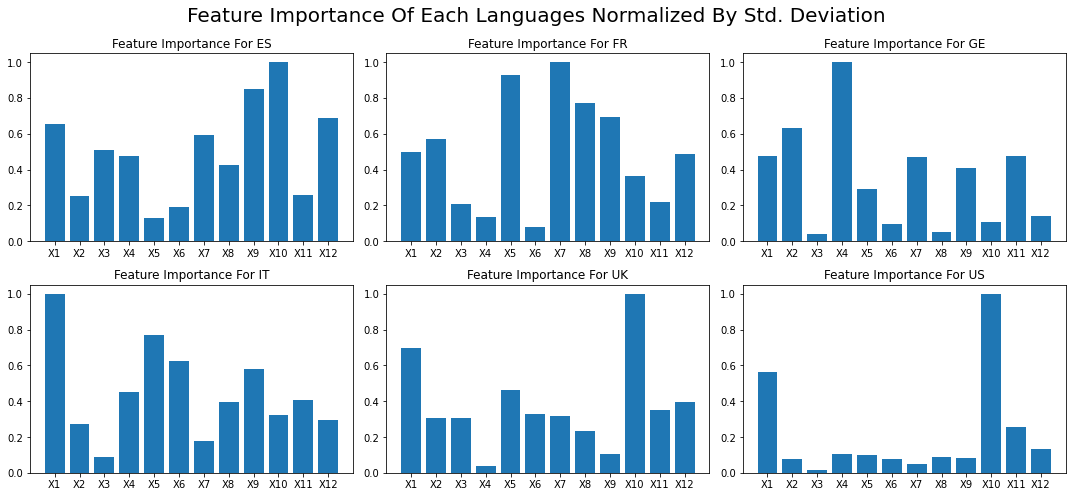

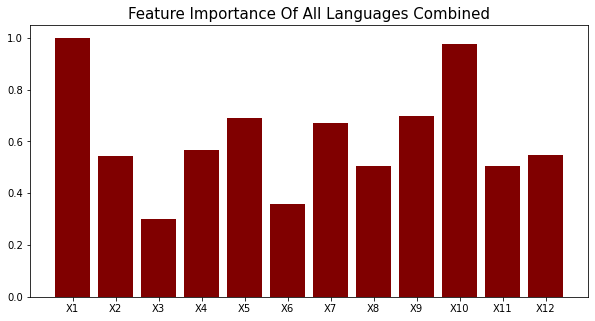

In [192]:
best_alphas = []
importances = []
feature_names = np.array(df.columns[1:])
lable_names = np.unique(y_train[0])

for i in range(0, len(x_train)):

    ridge = RidgeClassifierCV(alphas=np.logspace(-6, 6, num=500)).fit(
        x_train[i], y_train[i]
    )
    best_alpha = ridge.alpha_
    best_alphas.append(best_alpha)

    # obtain coefficients
    ridge = RidgeClassifierCV(alphas=[best_alpha]).fit(x_train[i], y_train[i])
    importance = np.abs(ridge.coef_) 
    
    # scale coefficients by std-deviation
    std_dev = x_train[i].std(axis=0).tolist()
    for j in range(0,len(importance)):
        importance[j] = importance[j] * std_dev
    importances.append(importance)

# obtain average importances for all folds
importances_avg = importances[0].copy()
importances_avg.fill(0)

for f in range(0, len(feature_names)):
    for l in range(0, len(lable_names)):
        imp_sum = 0
        for i in range(0, len(importances)):
            # print("X",f,", L",l,":",importances[i][l][f],"\n\n")
            imp_sum += importances[i][l][f]
        imp_avg = imp_sum / len(importances)
        importances_avg[l][f] = imp_avg

best_alpha = np.average(best_alphas)

#normalize importances for plotting
for i in range(0, len(importances_avg)):
    _max = max(importances_avg[i])
    importances_avg[i] = [(j/_max) for j in importances_avg[i]]
importances_avg = np.array(importances_avg)

# plot importance of feature for each languages
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
for idx, lable in enumerate(lable_names):
    axs[(idx // 3), (idx % 3)].bar(height=importances_avg[idx], x=feature_names)
    axs[(idx // 3), (idx % 3)].set_title("Feature Importance For {0}".format(lable))
plt.suptitle("Feature Importance Of Each Languages Normalized By Std. Deviation",fontsize=20)
fig.tight_layout()
plt.show()

# plot importance of features for all languages combined

importances_total = importances_avg.mean(axis=0)
importances_total = [(j/max(importances_total)) for j in importances_total] #normalize
fig = plt.figure(figsize=(10, 5))
plt.bar(height=importances_total, x=feature_names, color="maroon")
plt.title("Feature Importance Of All Languages Combined",fontsize=15)
plt.show()

### Method: Result Display

A general method for all models to display confusion matrix, performance metrics etc after making predictions.

In [193]:
def showResultSummary(_y_test, _y_out, _title, _is_plot_result):
    
    # show confusion matrix
    _lables = np.union1d(_y_test, _y_out)
    _cm = confusion_matrix(_y_test, _y_out)
    if(_is_plot_result):
        _cmd = ConfusionMatrixDisplay(_cm, display_labels = _lables)
        _cmd.plot()
        _cmd.ax_.set(title = _title, 
                    xlabel = 'Predicted Language', 
                    ylabel = 'Actual Language')
        plt.show()
    
    # calculate accuracy, precision, recall, f-score
    _prf = precision_recall_fscore_support(_y_test, _y_out, average=None, labels=_lables, zero_division=0)
    _precision = _prf[0]
    _recall = _prf[1]
    _f_score = _prf[2]
    _accuracy = _cm.diagonal()/_cm.sum(axis=1)
    
    _prfAvg = precision_recall_fscore_support(_y_test, _y_out, average='weighted', zero_division=0)
    _precision_avg = _prfAvg[0]
    _recall_avg = _prfAvg[1]
    _f_score_avg = _prfAvg[2]
    _accuracy_avg = accuracy_score(_y_test, _y_out)

    # tabulate the result
    _resDf = pd.DataFrame(
        data={'Language': np.append(_lables , 'Average(weighted)'),
              'Accuracy': np.append(_accuracy, _accuracy_avg),
              'Precision': np.append(_precision, _precision_avg),
              'Recall': np.append(_recall, _recall_avg),
              'F-score': np.append(_f_score, _f_score_avg),
              })
    
    _resDf.set_index('Language')
    if(_is_plot_result):
        display(_resDf)
    return _resDf


###  Method: Classifier applicant

A general method to apply given classifier to each train/test folds and display the results
It also allows selecting subset selection, PCA, feature scaling to be used before making predictions

In [194]:
def applyClassifier(_clf, _config, _set_type, _title):
    _y_pred = [None] * len(x_train)
    _accuraciesForEachFold = []

    # train and test model for each k-fold
    for i in range(0, len(x_train)):
        
        # select train/test
        _train_data_x = x_train[i].copy()
        _train_data_y = y_train[i].copy()
        _test_data_x = []
        _test_data_y = []
        if(_set_type == setType.Train):
            _test_data_x = x_train[i].copy()
            _test_data_y = y_train[i].copy()
        elif(_set_type == setType.Test):
            _test_data_x = x_test[i].copy()
            _test_data_y = y_test[i].copy()
        _selected_features = df.columns[1:]  # all features

        # apply feature selection
        if _config["use_feature_selector"]:
            _sfs = SequentialFeatureSelector(
                _clf,
                n_features_to_select = _config["feature_selector_n_features"],
                direction = _config["feature_selector_direction"],
            )
            _sfs.fit(_train_data_x, _train_data_y)
            _selected_features = _sfs.get_feature_names_out(_selected_features)

        _X_train = _train_data_x[_selected_features]
        _X_test = _test_data_x[_selected_features]
        
        # apply feature scaling
        if _config["use_feature_scaling"]:
            _scale = StandardScaler()
            _X_train = _scale.fit_transform(_X_train)
            _X_test = _scale.transform(_X_test)

        # apply PCA
        if _config["use_pca"]:
            _pca = PCA(n_components = _config["pca_n_features"])
            _X_train = _pca.fit_transform(_X_train)
            _X_test = _pca.transform(_X_test)

        # fit and predict
        if setup.verbosity > 3 or _config["use_feature_selector"]:
            print(_title,", [{0}] classifying fold-{1}".format(_set_type.name, i), "with features:",
                " ".join(_selected_features))

        _start_time = time.time()
        _clf.fit(_X_train, _train_data_y)
        if(setup.verbosity > 4):
            print("It took", (time.time() - _start_time), "to train a single model")
        _y_pred[i] = _clf.predict(_X_test)

        # show results for each fold
        _is_plot_result = _config["show_each_fold_result"]
        _tmpAvgAccuracy = 0
        if _config["use_feature_selector"]:
            _tmpResDf = showResultSummary(_test_data_y, _y_pred[i],
                "Test K-fold: {0},  ({1} | Feature Subset: {2})".format(i, _title, " ".join(_selected_features)),
                _is_plot_result)
            _tmpAvgAccuracy = _tmpResDf.at[_tmpResDf["Language"].shape[0] - 1, "Accuracy"]

        else:
            _tmpResDf = showResultSummary(_test_data_y, _y_pred[i],
                "Test K-fold: {0},  ({1})".format(i, _title),
                _is_plot_result)
            _tmpAvgAccuracy = _tmpResDf.at[_tmpResDf["Language"].shape[0] - 1, "Accuracy"]
            
        # save accuracies for each fold
        _accuraciesForEachFold.append(_tmpAvgAccuracy)
        if setup.verbosity > 2:
            print(_title, ", [{0}] classification weighted accuracy for fold-{1}: ".format(_set_type.name, i),
                  _tmpAvgAccuracy)

    # show overall result by combining results of each k-fold
    _y_actual = []
    if(_set_type == setType.Train):
        _y_actual = y_train
    elif(_set_type == setType.Test):
        _y_actual = y_test
        
    _y_pred = np.array(_y_pred, dtype=object)
    _is_plot_result = _config["show_summary_result"]
    _resDf = showResultSummary(
        np.concatenate(_y_actual).ravel(),
        np.concatenate(_y_pred).ravel(),
        "All test K-folds combined, ({0})".format(_title),
        _is_plot_result,
    )

    _avgAccuracy = _resDf.at[_resDf["Language"].shape[0] - 1, "Accuracy"]
    if setup.verbosity > 1:
        print(_title, ", [{0}] average accuracy for all folds: ".format(_set_type.name), _avgAccuracy)
    return _avgAccuracy, _accuraciesForEachFold

### Method: Feature Selection

A general method to implement subset selection with given classifier on train/test folds and display the result

In [195]:
def classifyWithFeatureSelection(_clf, _config, _set_type, _title, _usePcaOverSubsetSel):
    # get min-max range of number of features
    _type_name=" (FW Subset Selection)"
    _min_n = setup.subset_selection_min_n
    _max_n = setup.subset_selection_max_n
    if(_usePcaOverSubsetSel):
        _type_name = ' (PCA)'
        _min_n = setup.subset_selection_min_n
        _max_n = setup.subset_selection_max_n
        
    # output containers
    _n_features = [int(i) for i in range(_min_n, _max_n + 1)] 
    _n_accuracies = []
    

    # apply forward subset selection/PCA
    for n in _n_features:
        _config_cpy = _config.copy()
        if(_usePcaOverSubsetSel):
            _config_cpy['use_pca'] = True
            _config_cpy['pca_n_features'] = n
            _config_cpy['use_feature_selector'] = False
        else:
            _config_cpy['use_feature_selector'] = True
            _config_cpy['feature_selector_direction'] = 'forward'
            _config_cpy['feature_selector_n_features'] = n
            _config_cpy['use_pca'] = False

        if(n == _max_n):
            _config_cpy['use_feature_selector'] = False
            _config_cpy['use_pca'] = False

        _title_mod = _title + _type_name + ", n={0}".format(n)
        _accuracy_clf, _all_accuracies_clf = applyClassifier(_clf, _config_cpy, _set_type, _title_mod)
        if(setup.verbosity > 3):
            print("For n=", n, ", accuracy=", _accuracy_clf)
        _n_accuracies.append(_accuracy_clf)

    return _n_features, _n_accuracies


## Predict KNN

###########################
 # Base Model
 ###########################

KNN base model , [Train] classification weighted accuracy for fold-0:  0.8631178707224335
KNN base model , [Train] classification weighted accuracy for fold-1:  0.8973384030418251
KNN base model , [Train] classification weighted accuracy for fold-2:  0.870722433460076
KNN base model , [Train] classification weighted accuracy for fold-3:  0.8859315589353612
KNN base model , [Train] classification weighted accuracy for fold-4:  0.9053030303030303


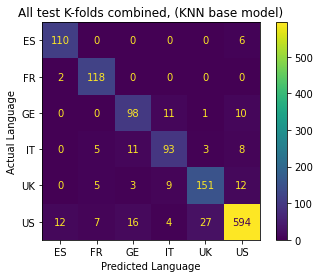

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.948276,0.887097,0.948276,0.916667
1,FR,0.983333,0.874074,0.983333,0.925490
2,GE,0.816667,0.765625,0.816667,0.790323
3,IT,0.775000,0.794872,0.775000,0.784810
4,UK,0.838889,0.829670,0.838889,0.834254
5,US,0.900000,0.942857,0.900000,0.920930
6,Average(weighted),0.884498,0.886534,0.884498,0.884793


KNN base model , [Train] average accuracy for all folds:  0.8844984802431611
RESULT: KNN(Base Model)
	 average-accuracy: 0.8844984802431611 
	 max-accuracy: 0.9053030303030303 
	 misclassification-rate: 0.11550151975683887 


KNN base model , [Test] classification weighted accuracy for fold-0:  0.803030303030303
KNN base model , [Test] classification weighted accuracy for fold-1:  0.8181818181818182
KNN base model , [Test] classification weighted accuracy for fold-2:  0.803030303030303
KNN base model , [Test] classification weighted accuracy for fold-3:  0.8484848484848485
KNN base model , [Test] classification weighted accuracy for fold-4:  0.7384615384615385


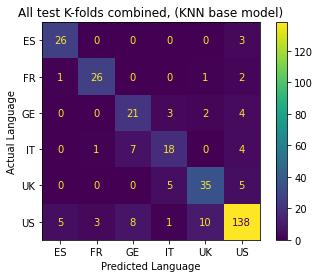

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.896552,0.812500,0.896552,0.852459
1,FR,0.866667,0.866667,0.866667,0.866667
2,GE,0.700000,0.583333,0.700000,0.636364
3,IT,0.600000,0.666667,0.600000,0.631579
4,UK,0.777778,0.729167,0.777778,0.752688
5,US,0.836364,0.884615,0.836364,0.859813
6,Average(weighted),0.802432,0.808014,0.802432,0.803951


KNN base model , [Test] average accuracy for all folds:  0.8024316109422492
RESULT: KNN(Base Model)
	 average-accuracy: 0.8024316109422492 
	 max-accuracy: 0.8484848484848485 
	 misclassification-rate: 0.19756838905775076 


###########################
 # Hyper-parameter tuning
 ###########################

KNN : k=1 , [Test] classification weighted accuracy for fold-0:  0.8484848484848485
KNN : k=1 , [Test] classification weighted accuracy for fold-1:  0.7878787878787878
KNN : k=1 , [Test] classification weighted accuracy for fold-2:  0.7878787878787878
KNN : k=1 , [Test] classification weighted accuracy for fold-3:  0.8181818181818182
KNN : k=1 , [Test] classification weighted accuracy for fold-4:  0.8307692307692308
KNN : k=1 , [Test] average accuracy for all folds:  0.8145896656534954
KNN : k=2 , [Test] classification weighted accuracy for fold-0:  0.803030303030303
KNN : k=2 , [Test] classification weighted accuracy for fold-1:  0.7575757575757576
KNN : k=2 , [Test] classification

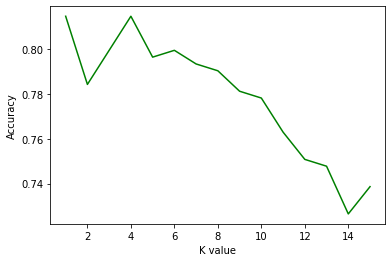

###########################
 # feature selection
 ###########################

KNN : k=1 (FW Subset Selection), n=5 , [Test] classifying fold-0 with features: X4 X6 X7 X8 X10
KNN : k=1 (FW Subset Selection), n=5 , [Test] classification weighted accuracy for fold-0:  0.6212121212121212
KNN : k=1 (FW Subset Selection), n=5 , [Test] classifying fold-1 with features: X1 X5 X8 X9 X10
KNN : k=1 (FW Subset Selection), n=5 , [Test] classification weighted accuracy for fold-1:  0.6212121212121212
KNN : k=1 (FW Subset Selection), n=5 , [Test] classifying fold-2 with features: X2 X3 X7 X10 X11
KNN : k=1 (FW Subset Selection), n=5 , [Test] classification weighted accuracy for fold-2:  0.6060606060606061
KNN : k=1 (FW Subset Selection), n=5 , [Test] classifying fold-3 with features: X1 X5 X8 X10 X11
KNN : k=1 (FW Subset Selection), n=5 , [Test] classification weighted accuracy for fold-3:  0.5909090909090909
KNN : k=1 (FW Subset Selection), n=5 , [Test] classifying fold-4 with features: X1 X4 X5 X1

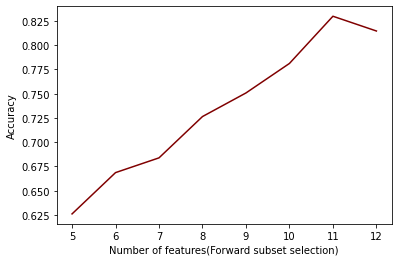

KNN : k=1 (PCA), n=5 , [Test] classification weighted accuracy for fold-0:  0.5757575757575758
KNN : k=1 (PCA), n=5 , [Test] classification weighted accuracy for fold-1:  0.6212121212121212
KNN : k=1 (PCA), n=5 , [Test] classification weighted accuracy for fold-2:  0.5606060606060606
KNN : k=1 (PCA), n=5 , [Test] classification weighted accuracy for fold-3:  0.6060606060606061
KNN : k=1 (PCA), n=5 , [Test] classification weighted accuracy for fold-4:  0.6307692307692307
KNN : k=1 (PCA), n=5 , [Test] average accuracy for all folds:  0.5987841945288754
KNN : k=1 (PCA), n=6 , [Test] classification weighted accuracy for fold-0:  0.6363636363636364
KNN : k=1 (PCA), n=6 , [Test] classification weighted accuracy for fold-1:  0.6212121212121212
KNN : k=1 (PCA), n=6 , [Test] classification weighted accuracy for fold-2:  0.6212121212121212
KNN : k=1 (PCA), n=6 , [Test] classification weighted accuracy for fold-3:  0.6515151515151515
KNN : k=1 (PCA), n=6 , [Test] classification weighted accuracy 

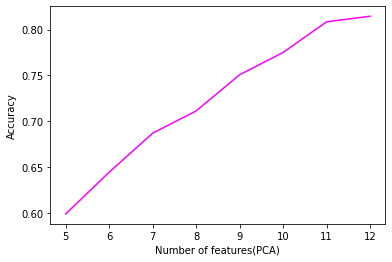

###########################
 # Final Model
 ###########################

KNN final model , [Train] classifying fold-0 with features: X1 X2 X4 X5 X6 X7 X8 X9 X10 X11 X12
KNN final model , [Train] classification weighted accuracy for fold-0:  1.0
KNN final model , [Train] classifying fold-1 with features: X1 X2 X4 X5 X6 X7 X8 X9 X10 X11 X12
KNN final model , [Train] classification weighted accuracy for fold-1:  1.0
KNN final model , [Train] classifying fold-2 with features: X1 X2 X3 X4 X6 X7 X8 X9 X10 X11 X12
KNN final model , [Train] classification weighted accuracy for fold-2:  1.0
KNN final model , [Train] classifying fold-3 with features: X1 X2 X3 X5 X6 X7 X8 X9 X10 X11 X12
KNN final model , [Train] classification weighted accuracy for fold-3:  1.0
KNN final model , [Train] classifying fold-4 with features: X1 X2 X4 X5 X6 X7 X8 X9 X10 X11 X12
KNN final model , [Train] classification weighted accuracy for fold-4:  1.0


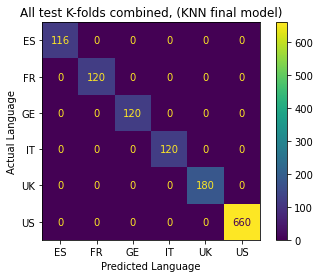

,Language,Accuracy,Precision,Recall,F-score
0,ES,1.0,1.0,1.0,1.0
1,FR,1.0,1.0,1.0,1.0
2,GE,1.0,1.0,1.0,1.0
3,IT,1.0,1.0,1.0,1.0
4,UK,1.0,1.0,1.0,1.0
5,US,1.0,1.0,1.0,1.0
6,Average(weighted),1.0,1.0,1.0,1.0


KNN final model , [Train] average accuracy for all folds:  1.0
RESULT: KNN(Final Model)
	 average-accuracy: 1.0 
	 max-accuracy: 1.0 
	 misclassification-rate: 0.0 


KNN final model , [Test] classifying fold-0 with features: X1 X2 X4 X5 X6 X7 X8 X9 X10 X11 X12
KNN final model , [Test] classification weighted accuracy for fold-0:  0.8787878787878788
KNN final model , [Test] classifying fold-1 with features: X1 X2 X4 X5 X6 X7 X8 X9 X10 X11 X12
KNN final model , [Test] classification weighted accuracy for fold-1:  0.803030303030303
KNN final model , [Test] classifying fold-2 with features: X1 X2 X3 X4 X6 X7 X8 X9 X10 X11 X12
KNN final model , [Test] classification weighted accuracy for fold-2:  0.7727272727272727
KNN final model , [Test] classifying fold-3 with features: X1 X2 X3 X5 X6 X7 X8 X9 X10 X11 X12
KNN final model , [Test] classification weighted accuracy for fold-3:  0.8333333333333334
KNN final model , [Test] classifying fold-4 with features: X1 X2 X4 X5 X6 X7 X8 X9 X10 X11 X12

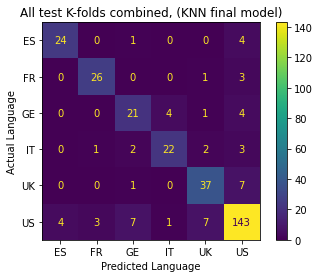

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.827586,0.857143,0.827586,0.842105
1,FR,0.866667,0.866667,0.866667,0.866667
2,GE,0.700000,0.656250,0.700000,0.677419
3,IT,0.733333,0.814815,0.733333,0.771930
4,UK,0.822222,0.770833,0.822222,0.795699
5,US,0.866667,0.871951,0.866667,0.869301
6,Average(weighted),0.829787,0.831455,0.829787,0.830221


KNN final model , [Test] average accuracy for all folds:  0.8297872340425532
RESULT: KNN(Final Model)
	 average-accuracy: 0.8297872340425532 
	 max-accuracy: 0.8787878787878788 
	 misclassification-rate: 0.17021276595744683 




In [196]:

#-----------------------------
# STEP: 0 Run Base
#-----------------------------
print(
        "###########################\n",
        "# Base Model\n",
        "###########################\n",
    )

config = {
    "use_feature_scaling": False,
    "use_pca": False,
    "use_feature_selector": False,
    "show_each_fold_result": False,
    "show_summary_result": True,
}

for set_type in [setType.Train, setType.Test]:
    avg_accuracy, fold_accuracies = applyClassifier(
        KNeighborsClassifier(), config, set_type, "KNN base model"
    )
    print("RESULT: KNN(Base Model)\n\t average-accuracy:", avg_accuracy,"\n\t max-accuracy:",
          max(fold_accuracies), "\n\t misclassification-rate:", (1.0 - avg_accuracy), "\n\n")

#-----------------------------
# STEP 1: Hyper-parameter Tuning
#-----------------------------
print(
    "###########################\n",
    "# Hyper-parameter tuning\n",
    "###########################\n",
)

config = {
    "use_feature_scaling": True,
    "use_pca": False,
    "use_feature_selector": False,
    "show_each_fold_result": False,
    "show_summary_result": False,
}

# Test K value from 1 to 15
k_values = [i for i in range(1, 15 + 1)]  
k_accuracies = []
all_k_accuracies = []
for k in k_values:
    avg_accuracy, fold_accuracies = applyClassifier(
        KNeighborsClassifier(n_neighbors=k), config, setType.Test, "KNN : k={0}".format(k)
    )
    k_accuracies.append(avg_accuracy)
    all_k_accuracies.extend(fold_accuracies)

# Get the best K
best_accuracy = max(k_accuracies)
best_k = k_values[k_accuracies.index(best_accuracy)]
max_accuracy = max(all_k_accuracies)
print("\nRESULT(Parameter Tuning): \n\t best k =", best_k, "\n\t average-accuracy=", best_accuracy, 
      "\n\t max-accuracy=", max_accuracy, "\n\t misclassification-rate:", (1.0 - best_accuracy), "\n\n")

# plot 'K' vs accuracy
plt.plot(k_values, k_accuracies, color="green")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.show()

#-----------------------------
# STEP 2: Feature selection
#-----------------------------
best_n = 12
do_pca = False
do_fss = False
if setup.skip_subset_selection == False:
    print(
        "###########################\n",
        "# feature selection\n",
        "###########################\n",
    )
    
    ##### forward Subset Selection #####
    config = {
        "use_feature_scaling": True,
        "use_pca": True,
        "use_feature_selector": False,
        "show_each_fold_result": False,
        "show_summary_result": False,
    }

    n_features, n_avg_accuracies = classifyWithFeatureSelection(
        KNeighborsClassifier(n_neighbors=best_k), config, setType.Test, "KNN : k={0}".format(best_k), False)

    # get best 'n'
    best_fss_accuracy = max(n_avg_accuracies)
    best_fss_n = n_features[n_avg_accuracies.index(best_fss_accuracy)]
    print("\nRESULT(Forward subset selection): \n\t best n =", best_fss_n, "\n\t average-accuracy=",
          best_fss_accuracy, "\n\t misclassification-rate:", (1.0 - best_fss_accuracy), "\n\n")

    # plot 'n' vs accuracy
    plt.plot(n_features, n_avg_accuracies, color ='maroon')
    plt.xlabel("Number of features(Forward subset selection)")
    plt.ylabel("Accuracy")
    plt.show()
    
    ##### PCA #####
    config = {
        "use_feature_scaling": True,
        "use_pca": True,
        "use_feature_selector": False,
        "show_each_fold_result": False,
        "show_summary_result": False,
    }

    n_features, n_avg_accuracies = classifyWithFeatureSelection(
        KNeighborsClassifier(n_neighbors=best_k), config, setType.Test, "KNN : k={0}".format(best_k), True)

    # get best 'n'
    best_pca_accuracy = max(n_avg_accuracies)
    best_pca_n = n_features[n_avg_accuracies.index(best_pca_accuracy)]
    print("\nRESULT(PCA): \n\t best n =", best_pca_n, "\n\t average-accuracy=", best_pca_accuracy, 
          "\n\t misclassification-rate:", (1.0 - best_pca_accuracy), "\n\n")

    # plot 'n' vs accuracy
    plt.plot(n_features, n_avg_accuracies, color="magenta")
    plt.xlabel("Number of features(PCA)")
    plt.ylabel("Accuracy")
    plt.show()
    
    ##### pick best PCA or FW Subset selection #####
    if(best_pca_accuracy > best_fss_accuracy):
        if(best_pca_n < best_n):
            best_n = best_pca_n
            do_pca = True
    else:
        if(best_fss_n < best_n):
            best_n = best_fss_n
            do_fss = True

#-----------------------------
# STEP: 3 Run Final Optimized Model
#-----------------------------
print(
        "###########################\n",
        "# Final Model\n",
        "###########################\n",
    )

config = {
    "use_feature_scaling": True,
    "use_pca": do_pca,
    "use_feature_selector": do_fss,
    "pca_n_features": best_n,
    "feature_selector_n_features": best_n,
    "feature_selector_direction": "forward",
    "show_each_fold_result": False,
    "show_summary_result": True,
}

for set_type in [setType.Train, setType.Test]:
    avg_accuracy, fold_accuracies = applyClassifier(
        KNeighborsClassifier(n_neighbors=best_k), config, set_type, "KNN final model")
    print("RESULT: KNN(Final Model)\n\t average-accuracy:", avg_accuracy, "\n\t max-accuracy:", 
          max(fold_accuracies), "\n\t misclassification-rate:", (1.0 - avg_accuracy), "\n\n")

## Predict Logistic Regression

###########################
 # Base Model
 ###########################

Logistic-Regression base model , [Train] classification weighted accuracy for fold-0:  0.7756653992395437
Logistic-Regression base model , [Train] classification weighted accuracy for fold-1:  0.7984790874524715
Logistic-Regression base model , [Train] classification weighted accuracy for fold-2:  0.7946768060836502
Logistic-Regression base model , [Train] classification weighted accuracy for fold-3:  0.7832699619771863
Logistic-Regression base model , [Train] classification weighted accuracy for fold-4:  0.7954545454545454


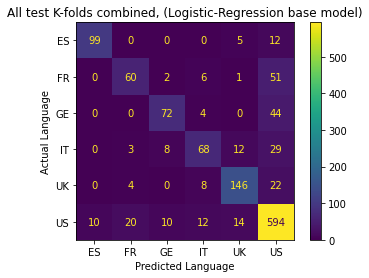

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.853448,0.908257,0.853448,0.880000
1,FR,0.500000,0.689655,0.500000,0.579710
2,GE,0.600000,0.782609,0.600000,0.679245
3,IT,0.566667,0.693878,0.566667,0.623853
4,UK,0.811111,0.820225,0.811111,0.815642
5,US,0.900000,0.789894,0.900000,0.841360
6,Average(weighted),0.789514,0.785916,0.789514,0.782774


Logistic-Regression base model , [Train] average accuracy for all folds:  0.7895136778115501
RESULT: Logistic-Regression(Base Model)
	 average-accuracy: 0.7895136778115501 
	 max-accuracy: 0.7984790874524715 
	 misclassification-rate: 0.21048632218844987 


Logistic-Regression base model , [Test] classification weighted accuracy for fold-0:  0.7424242424242424
Logistic-Regression base model , [Test] classification weighted accuracy for fold-1:  0.7424242424242424
Logistic-Regression base model , [Test] classification weighted accuracy for fold-2:  0.7575757575757576
Logistic-Regression base model , [Test] classification weighted accuracy for fold-3:  0.696969696969697
Logistic-Regression base model , [Test] classification weighted accuracy for fold-4:  0.6923076923076923


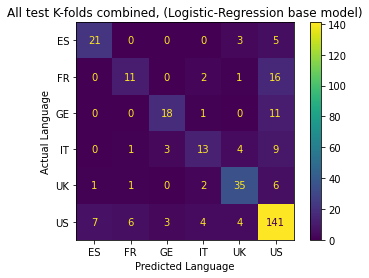

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.724138,0.724138,0.724138,0.724138
1,FR,0.366667,0.578947,0.366667,0.448980
2,GE,0.600000,0.750000,0.600000,0.666667
3,IT,0.433333,0.590909,0.433333,0.500000
4,UK,0.777778,0.744681,0.777778,0.760870
5,US,0.854545,0.750000,0.854545,0.798867
6,Average(weighted),0.726444,0.716889,0.726444,0.715871


Logistic-Regression base model , [Test] average accuracy for all folds:  0.7264437689969605
RESULT: Logistic-Regression(Base Model)
	 average-accuracy: 0.7264437689969605 
	 max-accuracy: 0.7575757575757576 
	 misclassification-rate: 0.2735562310030395 


###########################
 # parameter tuning
 ###########################

Logistic-Regresion (newton-cg, l2, 100) , [Test] classification weighted accuracy for fold-0:  0.7424242424242424
Logistic-Regresion (newton-cg, l2, 100) , [Test] classification weighted accuracy for fold-1:  0.7424242424242424
Logistic-Regresion (newton-cg, l2, 100) , [Test] classification weighted accuracy for fold-2:  0.7424242424242424
Logistic-Regresion (newton-cg, l2, 100) , [Test] classification weighted accuracy for fold-3:  0.6818181818181818
Logistic-Regresion (newton-cg, l2, 100) , [Test] classification weighted accuracy for fold-4:  0.676923076923077
Logistic-Regresion (newton-cg, l2, 100) , [Test] average accuracy for all folds:  0.7173252279635

Logistic-Regresion (liblinear, l1, 0.1) , [Test] classification weighted accuracy for fold-2:  0.6212121212121212
Logistic-Regresion (liblinear, l1, 0.1) , [Test] classification weighted accuracy for fold-3:  0.5606060606060606
Logistic-Regresion (liblinear, l1, 0.1) , [Test] classification weighted accuracy for fold-4:  0.5692307692307692
Logistic-Regresion (liblinear, l1, 0.1) , [Test] average accuracy for all folds:  0.5866261398176292
Logistic-Regresion (liblinear, l1, 0.01) , [Test] classification weighted accuracy for fold-0:  0.13636363636363635
Logistic-Regresion (liblinear, l1, 0.01) , [Test] classification weighted accuracy for fold-1:  0.13636363636363635
Logistic-Regresion (liblinear, l1, 0.01) , [Test] classification weighted accuracy for fold-2:  0.13636363636363635
Logistic-Regresion (liblinear, l1, 0.01) , [Test] classification weighted accuracy for fold-3:  0.13636363636363635
Logistic-Regresion (liblinear, l1, 0.01) , [Test] classification weighted accuracy for fold-4

Logistic-Regression (FW Subset Selection), n=8 , [Test] classifying fold-0 with features: X1 X2 X3 X5 X7 X9 X10 X12
Logistic-Regression (FW Subset Selection), n=8 , [Test] classification weighted accuracy for fold-0:  0.7575757575757576
Logistic-Regression (FW Subset Selection), n=8 , [Test] classifying fold-1 with features: X1 X3 X4 X7 X8 X9 X10 X12
Logistic-Regression (FW Subset Selection), n=8 , [Test] classification weighted accuracy for fold-1:  0.6818181818181818
Logistic-Regression (FW Subset Selection), n=8 , [Test] classifying fold-2 with features: X1 X2 X5 X7 X8 X9 X10 X12
Logistic-Regression (FW Subset Selection), n=8 , [Test] classification weighted accuracy for fold-2:  0.7272727272727273
Logistic-Regression (FW Subset Selection), n=8 , [Test] classifying fold-3 with features: X1 X2 X3 X5 X6 X7 X9 X10
Logistic-Regression (FW Subset Selection), n=8 , [Test] classification weighted accuracy for fold-3:  0.6060606060606061
Logistic-Regression (FW Subset Selection), n=8 , [Tes

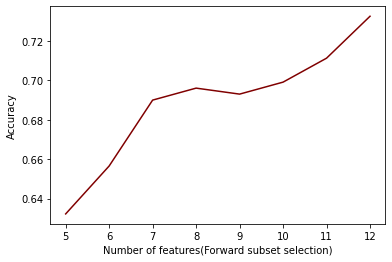

Logistic-Regression (PCA), n=5 , [Test] classification weighted accuracy for fold-0:  0.5151515151515151
Logistic-Regression (PCA), n=5 , [Test] classification weighted accuracy for fold-1:  0.5606060606060606
Logistic-Regression (PCA), n=5 , [Test] classification weighted accuracy for fold-2:  0.5151515151515151
Logistic-Regression (PCA), n=5 , [Test] classification weighted accuracy for fold-3:  0.5303030303030303
Logistic-Regression (PCA), n=5 , [Test] classification weighted accuracy for fold-4:  0.5538461538461539
Logistic-Regression (PCA), n=5 , [Test] average accuracy for all folds:  0.5349544072948328
Logistic-Regression (PCA), n=6 , [Test] classification weighted accuracy for fold-0:  0.5757575757575758
Logistic-Regression (PCA), n=6 , [Test] classification weighted accuracy for fold-1:  0.5909090909090909
Logistic-Regression (PCA), n=6 , [Test] classification weighted accuracy for fold-2:  0.5757575757575758
Logistic-Regression (PCA), n=6 , [Test] classification weighted accu

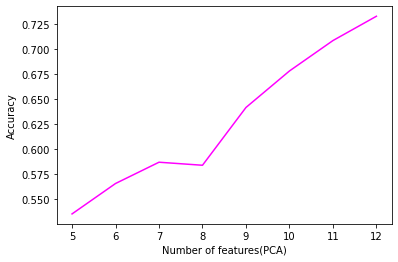

###########################
 # Final Model
 ###########################

Logistic-Regression final model , [Train] classification weighted accuracy for fold-0:  0.7642585551330798
Logistic-Regression final model , [Train] classification weighted accuracy for fold-1:  0.779467680608365
Logistic-Regression final model , [Train] classification weighted accuracy for fold-2:  0.7756653992395437
Logistic-Regression final model , [Train] classification weighted accuracy for fold-3:  0.7832699619771863
Logistic-Regression final model , [Train] classification weighted accuracy for fold-4:  0.7878787878787878


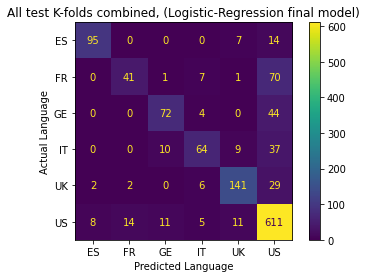

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.818966,0.904762,0.818966,0.859729
1,FR,0.341667,0.719298,0.341667,0.463277
2,GE,0.600000,0.765957,0.600000,0.672897
3,IT,0.533333,0.744186,0.533333,0.621359
4,UK,0.783333,0.834320,0.783333,0.808023
5,US,0.925758,0.759006,0.925758,0.834130
6,Average(weighted),0.778116,0.777817,0.778116,0.764895


Logistic-Regression final model , [Train] average accuracy for all folds:  0.7781155015197568
RESULT: Logistic-Regression(Final Model)
	 average-accuracy: 0.7781155015197568 
	 max-accuracy: 0.7878787878787878 
	 misclassification-rate: 0.22188449848024316 


Logistic-Regression final model , [Test] classification weighted accuracy for fold-0:  0.7727272727272727
Logistic-Regression final model , [Test] classification weighted accuracy for fold-1:  0.7272727272727273
Logistic-Regression final model , [Test] classification weighted accuracy for fold-2:  0.7424242424242424
Logistic-Regression final model , [Test] classification weighted accuracy for fold-3:  0.6818181818181818
Logistic-Regression final model , [Test] classification weighted accuracy for fold-4:  0.7384615384615385


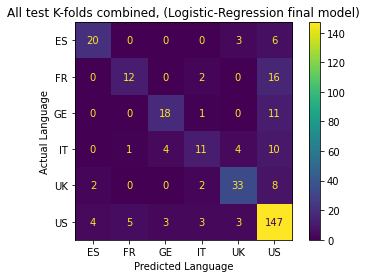

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.689655,0.769231,0.689655,0.727273
1,FR,0.400000,0.666667,0.400000,0.500000
2,GE,0.600000,0.720000,0.600000,0.654545
3,IT,0.366667,0.578947,0.366667,0.448980
4,UK,0.733333,0.767442,0.733333,0.750000
5,US,0.890909,0.742424,0.890909,0.809917
6,Average(weighted),0.732523,0.724350,0.732523,0.719097


Logistic-Regression final model , [Test] average accuracy for all folds:  0.7325227963525835
RESULT: Logistic-Regression(Final Model)
	 average-accuracy: 0.7325227963525835 
	 max-accuracy: 0.7727272727272727 
	 misclassification-rate: 0.26747720364741645 


Logistic-Regression C=[50, 10, 1.0, 0.1, 0.01] , [Test] classification weighted accuracy for fold-0:  0.7424242424242424
Logistic-Regression C=[50, 10, 1.0, 0.1, 0.01] , [Test] classification weighted accuracy for fold-1:  0.7424242424242424
Logistic-Regression C=[50, 10, 1.0, 0.1, 0.01] , [Test] classification weighted accuracy for fold-2:  0.7424242424242424
Logistic-Regression C=[50, 10, 1.0, 0.1, 0.01] , [Test] classification weighted accuracy for fold-3:  0.6818181818181818
Logistic-Regression C=[50, 10, 1.0, 0.1, 0.01] , [Test] classification weighted accuracy for fold-4:  0.676923076923077
Logistic-Regression C=[50, 10, 1.0, 0.1, 0.01] , [Test] average accuracy for all folds:  0.7173252279635258
Logistic-Regression C=[50, 10

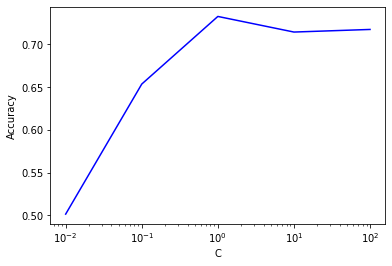

In [197]:

#-----------------------------
# STEP: 0 Run Base
#-----------------------------
print(
        "###########################\n",
        "# Base Model\n",
        "###########################\n",
    )

config = {
    "use_feature_scaling": False,
    "use_pca": False,
    "use_feature_selector": False,
    "show_each_fold_result": False,
    "show_summary_result": True,
}

for set_type in [setType.Train, setType.Test]:
    avg_accuracy, fold_accuracies = applyClassifier(
        LogisticRegression(random_state=0, multi_class="ovr", max_iter=1000),
            config, set_type ,"Logistic-Regression base model"
    )
    print("RESULT: Logistic-Regression(Base Model)\n\t average-accuracy:", avg_accuracy, "\n\t max-accuracy:",
          max(fold_accuracies), "\n\t misclassification-rate:", (1.0 - avg_accuracy), "\n\n")

#-----------------------------
# STEP 1: Parameter Tuning
#-----------------------------
print(
    "###########################\n",
    "# parameter tuning\n",
    "###########################\n",
)

config = {
    "use_feature_scaling": True,
    "use_pca": False,
    "use_feature_selector": False,
    "show_each_fold_result": False,
    "show_summary_result": False,
}

# generate all combinations of parameters
solvers = ["newton-cg", "lbfgs", "liblinear"]
penalty = ["l1", "l2"]
c_values = [100, 10, 1.0, 0.1, 0.01]
comm = list(itertools.product(solvers, penalty, c_values))
# remove invalid combinations
comm = [x for x in comm if not (x[0] in {"newton-cg", "lbfgs"} and x[1] == "l1")]

lr_accuracies = []
for para in comm:
    avg_accuracy, fold_accuracies = applyClassifier(
        LogisticRegression(
            random_state=0, multi_class="ovr", max_iter=1000,
            solver=para[0],
            penalty=para[1],
            C=para[2],
        ),
        config, setType.Test, "Logistic-Regresion (" + ", ".join(map(str, para)) + ")",
    )
    lr_accuracies.append(avg_accuracy)

best_accuracy = max(lr_accuracies)
_parameters = comm[lr_accuracies.index(best_accuracy)]
final_parameters = {'solver' : _parameters[0],
                    'penalty': _parameters[1], 
                    'C': _parameters[2]}


print("\nRESULT(Parameter Tuning):", "\n\t best-accuracy=", best_accuracy, 
      "\n\t best-prameters=", final_parameters, "\n\t misclassification-rate:", (1.0 - best_accuracy), "\n\n")

#-----------------------------
# STEP 2: Feature selection
#-----------------------------
best_n = 12
do_pca = False
do_fss = False
if setup.skip_subset_selection == False:
    print(
        "###########################\n",
        "# feature selection\n",
        "###########################\n",
    )
    
    ##### forward Subset Selection #####
    config = {
        "use_feature_scaling": True,
        "use_pca": True,
        "use_feature_selector": False,
        "show_each_fold_result": False,
        "show_summary_result": False,
    }

    n_features, n_avg_accuracies = classifyWithFeatureSelection(
        LogisticRegression(
            random_state=0, multi_class="ovr", max_iter=1000,
            solver=final_parameters["solver"],
            penalty=final_parameters["penalty"],
            C=final_parameters["C"],
        ),
        config, setType.Test, "Logistic-Regression", False)
    
    # get best 'n'
    best_fss_accuracy = max(n_avg_accuracies)
    best_fss_n = n_features[n_avg_accuracies.index(best_fss_accuracy)]
    print("\nRESULT(Forward subset selection): \n\t best n =", best_fss_n, "\n\t average-accuracy=",
          best_fss_accuracy, "\n\t misclassification-rate:", (1.0 - best_fss_accuracy), "\n\n")

    # plot 'n' vs accuracy
    plt.plot(n_features, n_avg_accuracies, color ='maroon')
    plt.xlabel("Number of features(Forward subset selection)")
    plt.ylabel("Accuracy")
    plt.show()
    
    ##### PCA #####
    config = {
        "use_feature_scaling": True,
        "use_pca": True,
        "use_feature_selector": False,
        "show_each_fold_result": False,
        "show_summary_result": False,
    }

    n_features, n_avg_accuracies = classifyWithFeatureSelection(
        LogisticRegression(
            random_state=0, multi_class="ovr", max_iter=1000,
            solver=final_parameters["solver"],
            penalty=final_parameters["penalty"],
            C=final_parameters["C"],
        ),
        config, setType.Test, "Logistic-Regression", True)
    
    # get best 'n'
    best_pca_accuracy = max(n_avg_accuracies)
    best_pca_n = n_features[n_avg_accuracies.index(best_pca_accuracy)]
    print("\nRESULT(PCA): \n\t best n =", best_pca_n, "\n\t average-accuracy=", best_pca_accuracy, 
          "\n\t misclassification-rate:", (1.0 - best_pca_accuracy), "\n\n")

    # plot 'n' vs accuracy
    plt.plot(n_features, n_avg_accuracies, color="magenta")
    plt.xlabel("Number of features(PCA)")
    plt.ylabel("Accuracy")
    plt.show()
    
    ##### pick best PCA or FW Subset selection #####
    if(best_pca_accuracy > best_fss_accuracy):
        if(best_pca_n < best_n):
            best_n = best_pca_n
            do_pca = True
    else:
        if(best_fss_n < best_n):
            best_n = best_fss_n
            do_fss = True

#-----------------------------
# STEP: 3 Run Final Optimized Model
#-----------------------------
print(
        "###########################\n",
        "# Final Model\n",
        "###########################\n",
    )

config = {
    "use_feature_scaling": True,
    "use_pca": do_pca,
    "use_feature_selector": do_fss,
    "pca_n_features": best_n,
    "feature_selector_n_features": best_n,
    "feature_selector_direction": "forward",
    "show_each_fold_result": False,
    "show_summary_result": True,
}

for set_type in [setType.Train, setType.Test]:
    avg_accuracy, fold_accuracies = applyClassifier(
        LogisticRegression(
                random_state=0, multi_class="ovr", max_iter=1000,
                solver=final_parameters["solver"],
                penalty=final_parameters["penalty"],
                C=final_parameters["C"],
            ),
            config, set_type, "Logistic-Regression final model"
    )
    print("RESULT: Logistic-Regression(Final Model)\n\t average-accuracy:", avg_accuracy, "\n\t max-accuracy:",
          max(fold_accuracies), "\n\t misclassification-rate:", (1.0 - avg_accuracy), "\n\n")
    
# plot C vs accuracy
config = {
    "use_feature_scaling": True,
    "use_pca": do_pca,
    "use_feature_selector": do_fss,
    "pca_n_features": best_n,
    "feature_selector_n_features": best_n,
    "feature_selector_direction": "forward",
    "show_each_fold_result": False,
    "show_summary_result": False,
}
c_list = [100, 10, 1.0, 0.1, 0.01]
accuracy_list = []
for c in c_list:
    avg_accuracy, fold_accuracies = applyClassifier(
        LogisticRegression(
                random_state=0, multi_class="ovr", max_iter=1000,
                solver=final_parameters["solver"],
                penalty=final_parameters["penalty"],
                C=c,
            ),
        config, set_type, "Logistic-Regression C={0}".format(C)
    )
    accuracy_list.append(avg_accuracy)
    
plt.plot(c_list, accuracy_list, color="blue")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.xscale('log')
plt.show()

## SVM

###########################
 # Base Model
 ###########################

SVM base model , [Train] classification weighted accuracy for fold-0:  0.6653992395437263
SVM base model , [Train] classification weighted accuracy for fold-1:  0.6996197718631179
SVM base model , [Train] classification weighted accuracy for fold-2:  0.6844106463878327
SVM base model , [Train] classification weighted accuracy for fold-3:  0.6806083650190115
SVM base model , [Train] classification weighted accuracy for fold-4:  0.7083333333333334


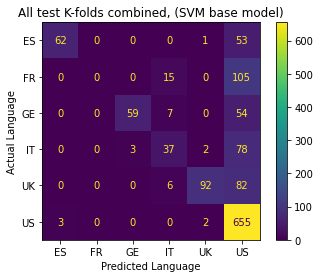

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.534483,0.953846,0.534483,0.685083
1,FR,0.000000,0.000000,0.000000,0.000000
2,GE,0.491667,0.951613,0.491667,0.648352
3,IT,0.308333,0.569231,0.308333,0.400000
4,UK,0.511111,0.948454,0.511111,0.664260
5,US,0.992424,0.637780,0.992424,0.776526
6,Average(weighted),0.687690,0.672343,0.687690,0.636281


SVM base model , [Train] average accuracy for all folds:  0.6876899696048632
RESULT: SVM(Base Model)
	 average-accuracy: 0.6876899696048632 
	 max-accuracy: 0.7083333333333334 
	 misclassification-rate: 0.31231003039513683 


SVM base model , [Test] classification weighted accuracy for fold-0:  0.7121212121212122
SVM base model , [Test] classification weighted accuracy for fold-1:  0.6515151515151515
SVM base model , [Test] classification weighted accuracy for fold-2:  0.6515151515151515
SVM base model , [Test] classification weighted accuracy for fold-3:  0.5757575757575758
SVM base model , [Test] classification weighted accuracy for fold-4:  0.6153846153846154


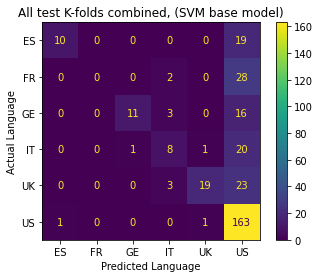

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.344828,0.909091,0.344828,0.500000
1,FR,0.000000,0.000000,0.000000,0.000000
2,GE,0.366667,0.916667,0.366667,0.523810
3,IT,0.266667,0.500000,0.266667,0.347826
4,UK,0.422222,0.904762,0.422222,0.575758
5,US,0.987879,0.605948,0.987879,0.751152
6,Average(weighted),0.641337,0.636958,0.641337,0.579022


SVM base model , [Test] average accuracy for all folds:  0.6413373860182371
RESULT: SVM(Base Model)
	 average-accuracy: 0.6413373860182371 
	 max-accuracy: 0.7121212121212122 
	 misclassification-rate: 0.3586626139817629 


###########################
 # parameter tuning
 ###########################

Fold-0, Best: 0.798186 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fold-1, Best: 0.798331 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fold-2, Best: 0.825254 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fold-3, Best: 0.821480 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fold-4, Best: 0.833309 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Best: 0.833309 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
###########################
 # feature selection
 ###########################

SVM (FW Subset Selection), n=5 , [Test] classifying fold-0 with features: X1 X5 X8 X10 X11
SVM (FW Subset Selection), n=5 , [Test] classification weighted accuracy for fold-0:  

SVM (FW Subset Selection), n=11 , [Test] classifying fold-4 with features: X1 X2 X3 X4 X5 X6 X7 X8 X10 X11 X12
SVM (FW Subset Selection), n=11 , [Test] classification weighted accuracy for fold-4:  0.8
SVM (FW Subset Selection), n=11 , [Test] average accuracy for all folds:  0.8115501519756839
SVM (FW Subset Selection), n=12 , [Test] classification weighted accuracy for fold-0:  0.9242424242424242
SVM (FW Subset Selection), n=12 , [Test] classification weighted accuracy for fold-1:  0.7878787878787878
SVM (FW Subset Selection), n=12 , [Test] classification weighted accuracy for fold-2:  0.7575757575757576
SVM (FW Subset Selection), n=12 , [Test] classification weighted accuracy for fold-3:  0.8484848484848485
SVM (FW Subset Selection), n=12 , [Test] classification weighted accuracy for fold-4:  0.8153846153846154
SVM (FW Subset Selection), n=12 , [Test] average accuracy for all folds:  0.8267477203647416

RESULT(Forward subset selection): 
	 best n = 12 
	 average-accuracy= 0.826747720

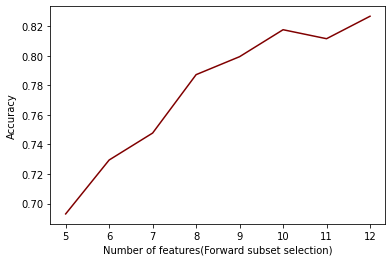

SVM (PCA), n=5 , [Test] classification weighted accuracy for fold-0:  0.6818181818181818
SVM (PCA), n=5 , [Test] classification weighted accuracy for fold-1:  0.7121212121212122
SVM (PCA), n=5 , [Test] classification weighted accuracy for fold-2:  0.6515151515151515
SVM (PCA), n=5 , [Test] classification weighted accuracy for fold-3:  0.6515151515151515
SVM (PCA), n=5 , [Test] classification weighted accuracy for fold-4:  0.6
SVM (PCA), n=5 , [Test] average accuracy for all folds:  0.6595744680851063
SVM (PCA), n=6 , [Test] classification weighted accuracy for fold-0:  0.6212121212121212
SVM (PCA), n=6 , [Test] classification weighted accuracy for fold-1:  0.6818181818181818
SVM (PCA), n=6 , [Test] classification weighted accuracy for fold-2:  0.6666666666666666
SVM (PCA), n=6 , [Test] classification weighted accuracy for fold-3:  0.696969696969697
SVM (PCA), n=6 , [Test] classification weighted accuracy for fold-4:  0.6923076923076923
SVM (PCA), n=6 , [Test] average accuracy for all f

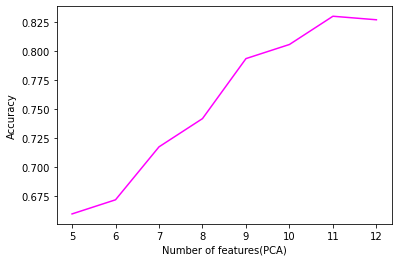

###########################
 # Final Model
 ###########################

SVM final model , [Train] classification weighted accuracy for fold-0:  0.973384030418251
SVM final model , [Train] classification weighted accuracy for fold-1:  0.9847908745247148
SVM final model , [Train] classification weighted accuracy for fold-2:  0.973384030418251
SVM final model , [Train] classification weighted accuracy for fold-3:  0.9809885931558935
SVM final model , [Train] classification weighted accuracy for fold-4:  0.9810606060606061


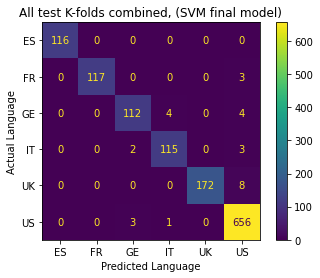

,Language,Accuracy,Precision,Recall,F-score
0,ES,1.000000,1.000000,1.000000,1.000000
1,FR,0.975000,1.000000,0.975000,0.987342
2,GE,0.933333,0.957265,0.933333,0.945148
3,IT,0.958333,0.958333,0.958333,0.958333
4,UK,0.955556,1.000000,0.955556,0.977273
5,US,0.993939,0.973294,0.993939,0.983508
6,Average(weighted),0.978723,0.978910,0.978723,0.978665


SVM final model , [Train] average accuracy for all folds:  0.9787234042553191
RESULT: SVM(Final Model)
	 average-accuracy: 0.9787234042553191 
	 max-accuracy: 0.9847908745247148 
	 misclassification-rate: 0.021276595744680882 


SVM final model , [Test] classification weighted accuracy for fold-0:  0.9393939393939394
SVM final model , [Test] classification weighted accuracy for fold-1:  0.803030303030303
SVM final model , [Test] classification weighted accuracy for fold-2:  0.7575757575757576
SVM final model , [Test] classification weighted accuracy for fold-3:  0.8636363636363636
SVM final model , [Test] classification weighted accuracy for fold-4:  0.7846153846153846


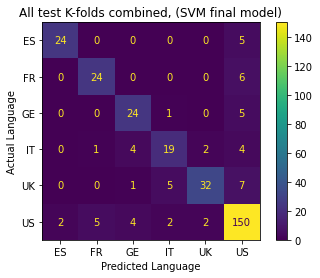

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.827586,0.923077,0.827586,0.872727
1,FR,0.800000,0.800000,0.800000,0.800000
2,GE,0.800000,0.727273,0.800000,0.761905
3,IT,0.633333,0.703704,0.633333,0.666667
4,UK,0.711111,0.888889,0.711111,0.790123
5,US,0.909091,0.847458,0.909091,0.877193
6,Average(weighted),0.829787,0.831395,0.829787,0.828142


SVM final model , [Test] average accuracy for all folds:  0.8297872340425532
RESULT: SVM(Final Model)
	 average-accuracy: 0.8297872340425532 
	 max-accuracy: 0.9393939393939394 
	 misclassification-rate: 0.17021276595744683 


SVM C=50 , [Test] classification weighted accuracy for fold-0:  0.8787878787878788
SVM C=50 , [Test] classification weighted accuracy for fold-1:  0.7727272727272727
SVM C=50 , [Test] classification weighted accuracy for fold-2:  0.7424242424242424
SVM C=50 , [Test] classification weighted accuracy for fold-3:  0.8787878787878788
SVM C=50 , [Test] classification weighted accuracy for fold-4:  0.7538461538461538
SVM C=50 , [Test] average accuracy for all folds:  0.8054711246200608
SVM C=10 , [Test] classification weighted accuracy for fold-0:  0.9393939393939394
SVM C=10 , [Test] classification weighted accuracy for fold-1:  0.803030303030303
SVM C=10 , [Test] classification weighted accuracy for fold-2:  0.7575757575757576
SVM C=10 , [Test] classification weighte

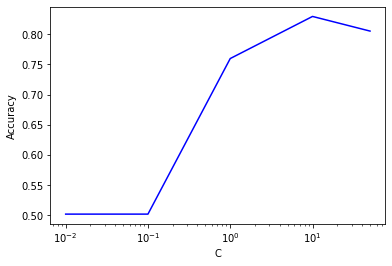

In [198]:
#-----------------------------
# STEP: 1 Run Base Model
#-----------------------------
print(
"###########################\n",
"# Base Model\n",
"###########################\n",
)

config = {
    "use_feature_scaling": False,
    "use_pca": False,
    "use_feature_selector": False,
    "show_each_fold_result": False,
    "show_summary_result": True,
}

for set_type in [setType.Train, setType.Test]:
    avg_accuracy, fold_accuracies = applyClassifier(
        svm.SVC(),
            config, set_type ,"SVM base model"
    )
    print("RESULT: SVM(Base Model)\n\t average-accuracy:", avg_accuracy, "\n\t max-accuracy:",
          max(fold_accuracies), "\n\t misclassification-rate:", (1.0 - avg_accuracy), "\n\n")


#-----------------------------
# STEP: 2 Tune Hyperparameters
#-----------------------------
print(
"###########################\n",
"# parameter tuning\n",
"###########################\n",
)
    
config = {
    "use_feature_scaling": True,
    "use_pca": False,
    "use_feature_selector": False,
    "show_each_fold_result": False,
    "show_summary_result": False,
}

prev_best = 0
final_parameters = {}
for i in range(0, len(x_train)):
    model = svm.SVC()
    kernel = ["poly", "rbf", "sigmoid"]
    C = [50, 10, 1.0, 0.1, 0.01]
    gamma = ["scale"]

    # define grid search
    grid = dict(kernel=kernel, C=C, gamma=gamma)
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=grid,
        n_jobs=-1,
        cv=cv,
        scoring="accuracy",
        error_score=0,
    )

    # feature scaling
    scale = StandardScaler()
    X_train = scale.fit_transform(x_train[i])
    X_test = scale.transform(x_test[i])
    grid_result = grid_search.fit(X_train, y_train[i])

    # summarize results
    if grid_result.best_score_ > prev_best:
        final_parameters = grid_result.best_params_
        prev_best = grid_result.best_score_

    print("Fold-%d, Best: %f using %s"
        % (i, grid_result.best_score_, grid_result.best_params_))

print("Final Best: %f using %s" % (prev_best, final_parameters))


#-----------------------------
# STEP 3: Feature selection
#-----------------------------
best_n = 12
do_pca = False
do_fss = False
if setup.skip_subset_selection == False:
    print(
        "###########################\n",
        "# feature selection\n",
        "###########################\n",
    )
    
    ##### forward Subset Selection #####
    config = {
        "use_feature_scaling": True,
        "use_pca": True,
        "use_feature_selector": False,
        "show_each_fold_result": False,
        "show_summary_result": False,
    }

    n_features, n_avg_accuracies = classifyWithFeatureSelection(
        svm.SVC(
            kernel=final_parameters["kernel"],
            gamma=final_parameters["gamma"],
            C=final_parameters["C"],
        ),
        config, setType.Test, "SVM", False)
    
    # get best 'n'
    best_fss_accuracy = max(n_avg_accuracies)
    best_fss_n = n_features[n_avg_accuracies.index(best_fss_accuracy)]
    print("\nRESULT(Forward subset selection): \n\t best n =", best_fss_n, "\n\t average-accuracy=",
          best_fss_accuracy, "\n\t misclassification-rate:", (1.0 - best_fss_accuracy), "\n\n")

    # plot 'n' vs accuracy
    plt.plot(n_features, n_avg_accuracies, color ='maroon')
    plt.xlabel("Number of features(Forward subset selection)")
    plt.ylabel("Accuracy")
    plt.show()
    
    ##### PCA #####
    config = {
        "use_feature_scaling": True,
        "use_pca": True,
        "use_feature_selector": False,
        "show_each_fold_result": False,
        "show_summary_result": False,
    }

    n_features, n_avg_accuracies = classifyWithFeatureSelection(
        svm.SVC(
            kernel=final_parameters["kernel"],
            gamma=final_parameters["gamma"],
            C=final_parameters["C"],
        ),
        config, setType.Test, "SVM", True)
    
    # get best 'n'
    best_pca_accuracy = max(n_avg_accuracies)
    best_pca_n = n_features[n_avg_accuracies.index(best_pca_accuracy)]
    print("\nRESULT(PCA): \n\t best n =", best_pca_n, "\n\t average-accuracy=", best_pca_accuracy, 
          "\n\t misclassification-rate:", (1.0 - best_pca_accuracy), "\n\n")

    # plot 'n' vs accuracy
    plt.plot(n_features, n_avg_accuracies, color="magenta")
    plt.xlabel("Number of features(PCA)")
    plt.ylabel("Accuracy")
    plt.show()
    
    ##### pick best PCA or FW Subset selection #####
    if(best_pca_accuracy > best_fss_accuracy):
        if(best_pca_n < best_n):
            best_n = best_pca_n
            do_pca = True
    else:
        if(best_fss_n < best_n):
            best_n = best_fss_n
            do_fss = True



    
#-----------------------------
# STEP: 4 Run Final Optimized Model
#-----------------------------
print(
        "###########################\n",
        "# Final Model\n",
        "###########################\n",
    )

config = {
    "use_feature_scaling": True,
    "use_pca": do_pca,
    "use_feature_selector": do_fss,
    "pca_n_features": best_n,
    "feature_selector_n_features": best_n,
    "feature_selector_direction": "forward",
    "show_each_fold_result": False,
    "show_summary_result": True,
}

for set_type in [setType.Train, setType.Test]:
    avg_accuracy, fold_accuracies = applyClassifier(
        svm.SVC(
            kernel=final_parameters["kernel"],
            gamma=final_parameters["gamma"],
            C=final_parameters["C"],
        ),
        config, set_type, "SVM final model"
    )
    print("RESULT: SVM(Final Model)\n\t average-accuracy:", avg_accuracy, "\n\t max-accuracy:",
          max(fold_accuracies), "\n\t misclassification-rate:", (1.0 - avg_accuracy), "\n\n")
    
# plot C vs accuracy
config = {
    "use_feature_scaling": True,
    "use_pca": do_pca,
    "use_feature_selector": do_fss,
    "pca_n_features": best_n,
    "feature_selector_n_features": best_n,
    "feature_selector_direction": "forward",
    "show_each_fold_result": False,
    "show_summary_result": False,
}
c_list = [50, 10, 1.0, 0.1, 0.01]
accuracy_list = []
for c in c_list:
    avg_accuracy, fold_accuracies = applyClassifier(
        svm.SVC(
            kernel=final_parameters["kernel"],
            gamma=final_parameters["gamma"],
            C=c,
        ),
        config, set_type, "SVM C={0}".format(c)
    )
    accuracy_list.append(avg_accuracy)
    
plt.plot(c_list, accuracy_list, color="blue")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.xscale('log')
plt.show()

## Desicion Tree

###########################
 # Base Model
 ###########################

Decision-Tree base model , [Train] classification weighted accuracy for fold-0:  1.0
Decision-Tree base model , [Train] classification weighted accuracy for fold-1:  1.0
Decision-Tree base model , [Train] classification weighted accuracy for fold-2:  1.0
Decision-Tree base model , [Train] classification weighted accuracy for fold-3:  1.0
Decision-Tree base model , [Train] classification weighted accuracy for fold-4:  1.0


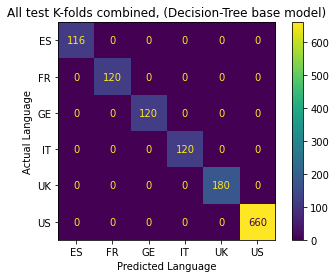

,Language,Accuracy,Precision,Recall,F-score
0,ES,1.0,1.0,1.0,1.0
1,FR,1.0,1.0,1.0,1.0
2,GE,1.0,1.0,1.0,1.0
3,IT,1.0,1.0,1.0,1.0
4,UK,1.0,1.0,1.0,1.0
5,US,1.0,1.0,1.0,1.0
6,Average(weighted),1.0,1.0,1.0,1.0


Decision-Tree base model , [Train] average accuracy for all folds:  1.0
RESULT: Decision-Tree(Base Model)
	 average-accuracy: 1.0 
	 max-accuracy: 1.0 
	 misclassification-rate: 0.0 


Decision-Tree base model , [Test] classification weighted accuracy for fold-0:  0.7424242424242424
Decision-Tree base model , [Test] classification weighted accuracy for fold-1:  0.6060606060606061
Decision-Tree base model , [Test] classification weighted accuracy for fold-2:  0.6666666666666666
Decision-Tree base model , [Test] classification weighted accuracy for fold-3:  0.6666666666666666
Decision-Tree base model , [Test] classification weighted accuracy for fold-4:  0.7230769230769231


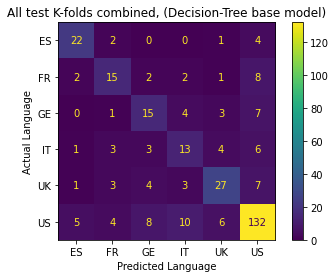

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.758621,0.709677,0.758621,0.733333
1,FR,0.500000,0.535714,0.500000,0.517241
2,GE,0.500000,0.468750,0.500000,0.483871
3,IT,0.433333,0.406250,0.433333,0.419355
4,UK,0.600000,0.642857,0.600000,0.620690
5,US,0.800000,0.804878,0.800000,0.802432
6,Average(weighted),0.680851,0.682783,0.680851,0.681498


Decision-Tree base model , [Test] average accuracy for all folds:  0.6808510638297872
RESULT: Decision-Tree(Base Model)
	 average-accuracy: 0.6808510638297872 
	 max-accuracy: 0.7424242424242424 
	 misclassification-rate: 0.3191489361702128 


###########################
 # parameter tuning
 ###########################

Fold-0, Best: 0.615965 using {'max_depth': 9, 'min_samples_split': 2}
Fold-1, Best: 0.664804 using {'max_depth': 8, 'min_samples_split': 3}
Fold-2, Best: 0.647025 using {'max_depth': 18, 'min_samples_split': 9}
Fold-3, Best: 0.672787 using {'max_depth': 7, 'min_samples_split': 12}
Fold-4, Best: 0.655660 using {'max_depth': 15, 'min_samples_split': 3}
Final Best: 0.672787 using {'max_depth': 7, 'min_samples_split': 12}
###########################
 # feature selection
 ###########################

Decision-Tree (FW Subset Selection), n=5 , [Test] classifying fold-0 with features: X1 X6 X8 X10 X11
Decision-Tree (FW Subset Selection), n=5 , [Test] classification weighted ac

Decision-Tree (FW Subset Selection), n=11 , [Test] classifying fold-1 with features: X1 X2 X3 X4 X5 X6 X7 X8 X9 X10 X11
Decision-Tree (FW Subset Selection), n=11 , [Test] classification weighted accuracy for fold-1:  0.5909090909090909
Decision-Tree (FW Subset Selection), n=11 , [Test] classifying fold-2 with features: X1 X2 X3 X4 X5 X6 X7 X8 X9 X10 X11
Decision-Tree (FW Subset Selection), n=11 , [Test] classification weighted accuracy for fold-2:  0.6666666666666666
Decision-Tree (FW Subset Selection), n=11 , [Test] classifying fold-3 with features: X1 X2 X3 X4 X5 X6 X8 X9 X10 X11 X12
Decision-Tree (FW Subset Selection), n=11 , [Test] classification weighted accuracy for fold-3:  0.6666666666666666
Decision-Tree (FW Subset Selection), n=11 , [Test] classifying fold-4 with features: X1 X2 X3 X5 X6 X7 X8 X9 X10 X11 X12
Decision-Tree (FW Subset Selection), n=11 , [Test] classification weighted accuracy for fold-4:  0.7076923076923077
Decision-Tree (FW Subset Selection), n=11 , [Test] ave

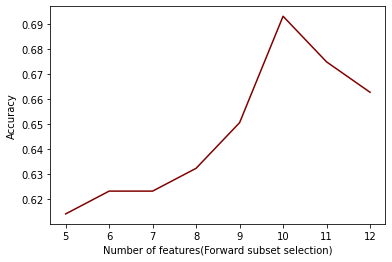

Decision-Tree (PCA), n=5 , [Test] classification weighted accuracy for fold-0:  0.5454545454545454
Decision-Tree (PCA), n=5 , [Test] classification weighted accuracy for fold-1:  0.5151515151515151
Decision-Tree (PCA), n=5 , [Test] classification weighted accuracy for fold-2:  0.5
Decision-Tree (PCA), n=5 , [Test] classification weighted accuracy for fold-3:  0.5757575757575758
Decision-Tree (PCA), n=5 , [Test] classification weighted accuracy for fold-4:  0.5692307692307692
Decision-Tree (PCA), n=5 , [Test] average accuracy for all folds:  0.541033434650456
Decision-Tree (PCA), n=6 , [Test] classification weighted accuracy for fold-0:  0.5303030303030303
Decision-Tree (PCA), n=6 , [Test] classification weighted accuracy for fold-1:  0.6363636363636364
Decision-Tree (PCA), n=6 , [Test] classification weighted accuracy for fold-2:  0.5606060606060606
Decision-Tree (PCA), n=6 , [Test] classification weighted accuracy for fold-3:  0.5606060606060606
Decision-Tree (PCA), n=6 , [Test] class

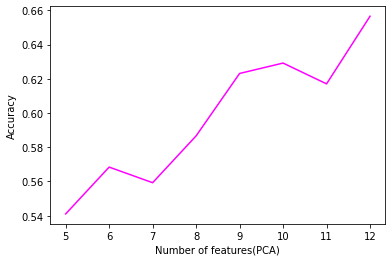

###########################
 # Final Model
 ###########################

Decision-Tree final model , [Train] classifying fold-0 with features: X1 X2 X3 X4 X5 X6 X8 X9 X10 X11
Decision-Tree final model , [Train] classification weighted accuracy for fold-0:  0.8517110266159695
Decision-Tree final model , [Train] classifying fold-1 with features: X1 X2 X3 X4 X5 X6 X8 X9 X10 X11
Decision-Tree final model , [Train] classification weighted accuracy for fold-1:  0.8365019011406845
Decision-Tree final model , [Train] classifying fold-2 with features: X1 X2 X3 X4 X5 X6 X8 X9 X10 X11
Decision-Tree final model , [Train] classification weighted accuracy for fold-2:  0.9011406844106464
Decision-Tree final model , [Train] classifying fold-3 with features: X1 X3 X4 X5 X6 X8 X9 X10 X11 X12
Decision-Tree final model , [Train] classification weighted accuracy for fold-3:  0.8517110266159695
Decision-Tree final model , [Train] classifying fold-4 with features: X1 X2 X3 X5 X6 X8 X9 X10 X11 X12
Decision-Tr

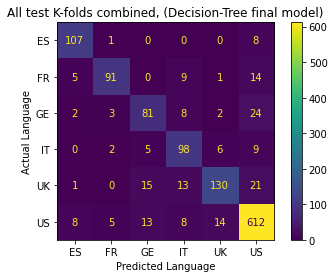

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.922414,0.869919,0.922414,0.895397
1,FR,0.758333,0.892157,0.758333,0.819820
2,GE,0.675000,0.710526,0.675000,0.692308
3,IT,0.816667,0.720588,0.816667,0.765625
4,UK,0.722222,0.849673,0.722222,0.780781
5,US,0.927273,0.889535,0.927273,0.908012
6,Average(weighted),0.850304,0.850864,0.850304,0.848803


Decision-Tree final model , [Train] average accuracy for all folds:  0.8503039513677811
RESULT: Decision-Tree(Final Model)
	 average-accuracy: 0.8503039513677811 
	 max-accuracy: 0.9011406844106464 
	 misclassification-rate: 0.14969604863221886 


Decision-Tree final model , [Test] classifying fold-0 with features: X1 X2 X3 X4 X5 X6 X8 X9 X10 X11
Decision-Tree final model , [Test] classification weighted accuracy for fold-0:  0.7424242424242424
Decision-Tree final model , [Test] classifying fold-1 with features: X1 X2 X3 X5 X6 X8 X9 X10 X11 X12
Decision-Tree final model , [Test] classification weighted accuracy for fold-1:  0.6060606060606061
Decision-Tree final model , [Test] classifying fold-2 with features: X1 X2 X4 X5 X6 X7 X8 X9 X10 X11
Decision-Tree final model , [Test] classification weighted accuracy for fold-2:  0.6515151515151515
Decision-Tree final model , [Test] classifying fold-3 with features: X1 X2 X4 X5 X6 X8 X9 X10 X11 X12
Decision-Tree final model , [Test] classificat

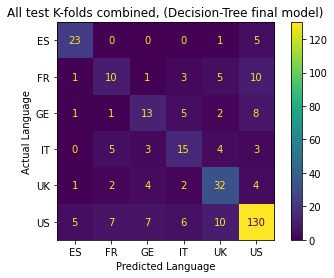

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.793103,0.741935,0.793103,0.766667
1,FR,0.333333,0.400000,0.333333,0.363636
2,GE,0.433333,0.464286,0.433333,0.448276
3,IT,0.500000,0.483871,0.500000,0.491803
4,UK,0.711111,0.592593,0.711111,0.646465
5,US,0.787879,0.812500,0.787879,0.800000
6,Average(weighted),0.677812,0.676869,0.677812,0.676096


Decision-Tree final model , [Test] average accuracy for all folds:  0.6778115501519757
RESULT: Decision-Tree(Final Model)
	 average-accuracy: 0.6778115501519757 
	 max-accuracy: 0.7424242424242424 
	 misclassification-rate: 0.3221884498480243 


Decision-Tree depth=1 , [Test] classifying fold-0 with features: X1 X2 X3 X4 X5 X6 X7 X8 X9 X10
Decision-Tree depth=1 , [Test] classification weighted accuracy for fold-0:  0.5
Decision-Tree depth=1 , [Test] classifying fold-1 with features: X1 X2 X3 X4 X5 X6 X7 X8 X9 X10
Decision-Tree depth=1 , [Test] classification weighted accuracy for fold-1:  0.5151515151515151
Decision-Tree depth=1 , [Test] classifying fold-2 with features: X1 X2 X3 X4 X5 X6 X7 X8 X9 X10
Decision-Tree depth=1 , [Test] classification weighted accuracy for fold-2:  0.5303030303030303
Decision-Tree depth=1 , [Test] classifying fold-3 with features: X1 X2 X3 X4 X5 X6 X7 X8 X9 X10
Decision-Tree depth=1 , [Test] classification weighted accuracy for fold-3:  0.5303030303030303
D

Decision-Tree depth=8 , [Test] classifying fold-4 with features: X3 X4 X5 X6 X7 X8 X9 X10 X11 X12
Decision-Tree depth=8 , [Test] classification weighted accuracy for fold-4:  0.6
Decision-Tree depth=8 , [Test] average accuracy for all folds:  0.6534954407294833
Decision-Tree depth=9 , [Test] classifying fold-0 with features: X1 X3 X4 X5 X6 X8 X9 X10 X11 X12
Decision-Tree depth=9 , [Test] classification weighted accuracy for fold-0:  0.7121212121212122
Decision-Tree depth=9 , [Test] classifying fold-1 with features: X1 X2 X3 X5 X6 X8 X9 X10 X11 X12
Decision-Tree depth=9 , [Test] classification weighted accuracy for fold-1:  0.5909090909090909
Decision-Tree depth=9 , [Test] classifying fold-2 with features: X1 X2 X3 X4 X5 X7 X9 X10 X11 X12
Decision-Tree depth=9 , [Test] classification weighted accuracy for fold-2:  0.6060606060606061
Decision-Tree depth=9 , [Test] classifying fold-3 with features: X1 X3 X4 X5 X6 X8 X9 X10 X11 X12
Decision-Tree depth=9 , [Test] classification weighted acc

Decision-Tree depth=16 , [Test] classifying fold-3 with features: X1 X3 X4 X5 X6 X8 X9 X10 X11 X12
Decision-Tree depth=16 , [Test] classification weighted accuracy for fold-3:  0.6515151515151515
Decision-Tree depth=16 , [Test] classifying fold-4 with features: X1 X2 X3 X4 X5 X7 X9 X10 X11 X12
Decision-Tree depth=16 , [Test] classification weighted accuracy for fold-4:  0.5538461538461539
Decision-Tree depth=16 , [Test] average accuracy for all folds:  0.6504559270516718
Decision-Tree depth=17 , [Test] classifying fold-0 with features: X1 X3 X4 X5 X6 X8 X9 X10 X11 X12
Decision-Tree depth=17 , [Test] classification weighted accuracy for fold-0:  0.7121212121212122
Decision-Tree depth=17 , [Test] classifying fold-1 with features: X1 X3 X4 X5 X6 X8 X9 X10 X11 X12
Decision-Tree depth=17 , [Test] classification weighted accuracy for fold-1:  0.6515151515151515
Decision-Tree depth=17 , [Test] classifying fold-2 with features: X1 X2 X3 X4 X5 X6 X8 X9 X10 X11
Decision-Tree depth=17 , [Test] cl

Decision-Tree depth=24 , [Test] classifying fold-2 with features: X1 X2 X3 X4 X5 X6 X8 X9 X10 X11
Decision-Tree depth=24 , [Test] classification weighted accuracy for fold-2:  0.6666666666666666
Decision-Tree depth=24 , [Test] classifying fold-3 with features: X1 X2 X4 X5 X6 X8 X9 X10 X11 X12
Decision-Tree depth=24 , [Test] classification weighted accuracy for fold-3:  0.6666666666666666
Decision-Tree depth=24 , [Test] classifying fold-4 with features: X1 X2 X3 X5 X6 X8 X9 X10 X11 X12
Decision-Tree depth=24 , [Test] classification weighted accuracy for fold-4:  0.7230769230769231
Decision-Tree depth=24 , [Test] average accuracy for all folds:  0.6747720364741642
Decision-Tree depth=25 , [Test] classifying fold-0 with features: X1 X2 X3 X4 X5 X6 X9 X10 X11 X12
Decision-Tree depth=25 , [Test] classification weighted accuracy for fold-0:  0.7121212121212122
Decision-Tree depth=25 , [Test] classifying fold-1 with features: X1 X2 X3 X5 X6 X8 X9 X10 X11 X12
Decision-Tree depth=25 , [Test] cl

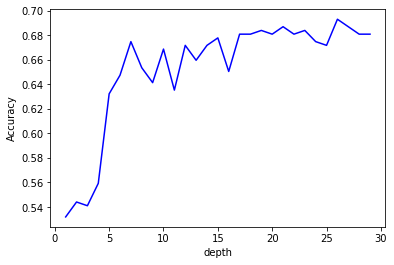

In [199]:
#-----------------------------
# STEP: 1 Run Base Model
#-----------------------------
print(
"###########################\n",
"# Base Model\n",
"###########################\n",
)

config = {
    "use_feature_scaling": False,
    "use_pca": False,
    "use_feature_selector": False,
    "show_each_fold_result": False,
    "show_summary_result": True,
}

for set_type in [setType.Train, setType.Test]:
    avg_accuracy, fold_accuracies = applyClassifier(
        DecisionTreeClassifier(),
        config, set_type ,"Decision-Tree base model"
    )
    print("RESULT: Decision-Tree(Base Model)\n\t average-accuracy:", avg_accuracy, "\n\t max-accuracy:",
          max(fold_accuracies), "\n\t misclassification-rate:", (1.0 - avg_accuracy), "\n\n")


#-----------------------------
# STEP: 2 Tune Hyperparameters
#-----------------------------
print(
"###########################\n",
"# parameter tuning\n",
"###########################\n",
)

prev_best = 0
final_parameters = {}
for i in range(0,len(x_train)):
    model = DecisionTreeClassifier()
    min_samples_split = list(range(2,20))
    max_depth = list(range(1,30))
    
    # define grid search
    grid = dict(min_samples_split=min_samples_split,
                max_depth=max_depth)
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    
    # feature scaling
    scale=StandardScaler()
    X_train = scale.fit_transform(x_train[i])
    X_test = scale.transform(x_test[i])
    grid_result = grid_search.fit(X_train, y_train[i])
    
    # summarize results
    if(grid_result.best_score_ > prev_best):
        final_parameters = grid_result.best_params_
        prev_best = grid_result.best_score_
        
    print("Fold-%d, Best: %f using %s" % (i,grid_result.best_score_, grid_result.best_params_))

print("Final Best: %f using %s" % (prev_best, final_parameters))


#-----------------------------
# STEP 3: Feature selection
#-----------------------------
best_n = 12
do_pca = False
do_fss = False
if setup.skip_subset_selection == False:
    print(
        "###########################\n",
        "# feature selection\n",
        "###########################\n",
    )
    
    ##### forward Subset Selection #####
    config = {
        "use_feature_scaling": True,
        "use_pca": True,
        "use_feature_selector": False,
        "show_each_fold_result": False,
        "show_summary_result": False,
    }

    n_features, n_avg_accuracies = classifyWithFeatureSelection(
        DecisionTreeClassifier(min_samples_split=final_parameters['min_samples_split'],
                               max_depth=final_parameters['max_depth']), 
        config, setType.Test, "Decision-Tree", False)
    
    # get best 'n'
    best_fss_accuracy = max(n_avg_accuracies)
    best_fss_n = n_features[n_avg_accuracies.index(best_fss_accuracy)]
    print("\nRESULT(Forward subset selection): \n\t best n =", best_fss_n, "\n\t average-accuracy=",
          best_fss_accuracy, "\n\t misclassification-rate:", (1.0 - best_fss_accuracy), "\n\n")

    # plot 'n' vs accuracy
    plt.plot(n_features, n_avg_accuracies, color ='maroon')
    plt.xlabel("Number of features(Forward subset selection)")
    plt.ylabel("Accuracy")
    plt.show()
    
    ##### PCA #####
    config = {
        "use_feature_scaling": True,
        "use_pca": True,
        "use_feature_selector": False,
        "show_each_fold_result": False,
        "show_summary_result": False,
    }

    n_features, n_avg_accuracies = classifyWithFeatureSelection(
        DecisionTreeClassifier(min_samples_split=final_parameters['min_samples_split'],
                               max_depth=final_parameters['max_depth']), 
        config, setType.Test, "Decision-Tree", True)
    
    # get best 'n'
    best_pca_accuracy = max(n_avg_accuracies)
    best_pca_n = n_features[n_avg_accuracies.index(best_pca_accuracy)]
    print("\nRESULT(PCA): \n\t best n =", best_pca_n, "\n\t average-accuracy=", best_pca_accuracy, 
          "\n\t misclassification-rate:", (1.0 - best_pca_accuracy), "\n\n")

    # plot 'n' vs accuracy
    plt.plot(n_features, n_avg_accuracies, color="magenta")
    plt.xlabel("Number of features(PCA)")
    plt.ylabel("Accuracy")
    plt.show()
    
    ##### pick best PCA or FW Subset selection #####
    if(best_pca_accuracy > best_fss_accuracy):
        if(best_pca_n < best_n):
            best_n = best_pca_n
            do_pca = True
    else:
        if(best_fss_n < best_n):
            best_n = best_fss_n
            do_fss = True


            

#-----------------------------
# STEP: 4 Run Final Optimized Model
#-----------------------------
print(
        "###########################\n",
        "# Final Model\n",
        "###########################\n",
    )

config = {
    "use_feature_scaling": True,
    "use_pca": do_pca,
    "use_feature_selector": do_fss,
    "pca_n_features": best_n,
    "feature_selector_n_features": best_n,
    "feature_selector_direction": "forward",
    "show_each_fold_result": False,
    "show_summary_result": True,
}

for set_type in [setType.Train, setType.Test]:
    avg_accuracy, fold_accuracies = applyClassifier(
        DecisionTreeClassifier(min_samples_split=final_parameters['min_samples_split'],
                               max_depth=final_parameters['max_depth']), 
        config, set_type, "Decision-Tree final model"
    )
    print("RESULT: Decision-Tree(Final Model)\n\t average-accuracy:", avg_accuracy, "\n\t max-accuracy:",
          max(fold_accuracies), "\n\t misclassification-rate:", (1.0 - avg_accuracy), "\n\n")
    
# plot n_estimators vs accuracy
config = {
    "use_feature_scaling": True,
    "use_pca": do_pca,
    "use_feature_selector": do_fss,
    "pca_n_features": best_n,
    "feature_selector_n_features": best_n,
    "feature_selector_direction": "forward",
    "show_each_fold_result": False,
    "show_summary_result": False,
}
depth_list = []
accuracy_list = []
for depth in range(1,30):
    avg_accuracy, fold_accuracies = applyClassifier(
        DecisionTreeClassifier(min_samples_split=final_parameters['min_samples_split'],
                               max_depth=depth), 
        config, set_type, "Decision-Tree depth={0}".format(depth)
    )
    depth_list.append(depth)
    accuracy_list.append(avg_accuracy)
    
# plot 'n' vs accuracy
plt.plot(depth_list, accuracy_list, color="blue")
plt.xlabel("depth")
plt.ylabel("Accuracy")
plt.show()

###########################
 # Base Model
 ###########################

Random-Forest base model , [Train] classification weighted accuracy for fold-0:  1.0
Random-Forest base model , [Train] classification weighted accuracy for fold-1:  1.0
Random-Forest base model , [Train] classification weighted accuracy for fold-2:  1.0
Random-Forest base model , [Train] classification weighted accuracy for fold-3:  1.0
Random-Forest base model , [Train] classification weighted accuracy for fold-4:  1.0


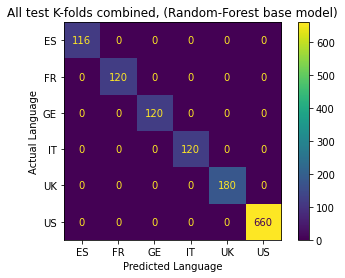

,Language,Accuracy,Precision,Recall,F-score
0,ES,1.0,1.0,1.0,1.0
1,FR,1.0,1.0,1.0,1.0
2,GE,1.0,1.0,1.0,1.0
3,IT,1.0,1.0,1.0,1.0
4,UK,1.0,1.0,1.0,1.0
5,US,1.0,1.0,1.0,1.0
6,Average(weighted),1.0,1.0,1.0,1.0


Random-Forest base model , [Train] average accuracy for all folds:  1.0
RESULT: Random-Forest(Base Model)
	 average-accuracy: 1.0 
	 max-accuracy: 1.0 
	 misclassification-rate: 0.0 


Random-Forest base model , [Test] classification weighted accuracy for fold-0:  0.9090909090909091
Random-Forest base model , [Test] classification weighted accuracy for fold-1:  0.7575757575757576
Random-Forest base model , [Test] classification weighted accuracy for fold-2:  0.7424242424242424
Random-Forest base model , [Test] classification weighted accuracy for fold-3:  0.7878787878787878
Random-Forest base model , [Test] classification weighted accuracy for fold-4:  0.7692307692307693


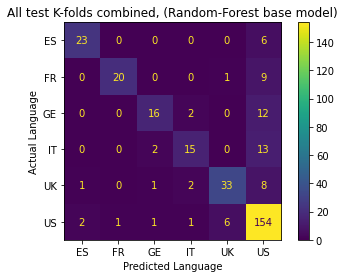

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.793103,0.884615,0.793103,0.836364
1,FR,0.666667,0.952381,0.666667,0.784314
2,GE,0.533333,0.800000,0.533333,0.640000
3,IT,0.500000,0.750000,0.500000,0.600000
4,UK,0.733333,0.825000,0.733333,0.776471
5,US,0.933333,0.762376,0.933333,0.839237
6,Average(weighted),0.793313,0.801345,0.793313,0.785408


Random-Forest base model , [Test] average accuracy for all folds:  0.7933130699088146
RESULT: Random-Forest(Base Model)
	 average-accuracy: 0.7933130699088146 
	 max-accuracy: 0.9090909090909091 
	 misclassification-rate: 0.20668693009118544 


###########################
 # parameter tuning
 ###########################

Fold-0, Best: 0.764441 using {'max_features': 'sqrt', 'n_estimators': 70}
Fold-1, Best: 0.779390 using {'max_features': 'sqrt', 'n_estimators': 50}
Fold-2, Best: 0.779173 using {'max_features': 'sqrt', 'n_estimators': 90}
Fold-3, Best: 0.771626 using {'max_features': 'sqrt', 'n_estimators': 50}
Fold-4, Best: 0.765167 using {'max_features': 'sqrt', 'n_estimators': 90}
Final Best: 0.779390 using {'max_features': 'sqrt', 'n_estimators': 50}
###########################
 # feature selection
 ###########################

Random-Forest (FW Subset Selection), n=5 , [Test] classifying fold-0 with features: X1 X4 X7 X10 X12
Random-Forest (FW Subset Selection), n=5 , [Test] class

Random-Forest (FW Subset Selection), n=11 , [Test] classifying fold-1 with features: X1 X2 X3 X5 X6 X7 X8 X9 X10 X11 X12
Random-Forest (FW Subset Selection), n=11 , [Test] classification weighted accuracy for fold-1:  0.7121212121212122
Random-Forest (FW Subset Selection), n=11 , [Test] classifying fold-2 with features: X1 X2 X3 X4 X5 X7 X8 X9 X10 X11 X12
Random-Forest (FW Subset Selection), n=11 , [Test] classification weighted accuracy for fold-2:  0.7272727272727273
Random-Forest (FW Subset Selection), n=11 , [Test] classifying fold-3 with features: X1 X2 X3 X4 X5 X6 X7 X8 X9 X10 X11
Random-Forest (FW Subset Selection), n=11 , [Test] classification weighted accuracy for fold-3:  0.7424242424242424
Random-Forest (FW Subset Selection), n=11 , [Test] classifying fold-4 with features: X1 X3 X4 X5 X6 X7 X8 X9 X10 X11 X12
Random-Forest (FW Subset Selection), n=11 , [Test] classification weighted accuracy for fold-4:  0.7846153846153846
Random-Forest (FW Subset Selection), n=11 , [Test] av

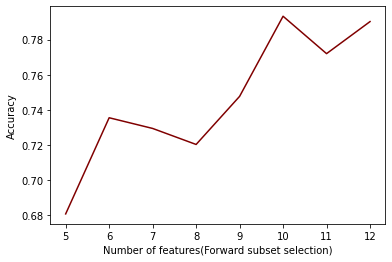

Decision-Tree (PCA), n=5 , [Test] classification weighted accuracy for fold-0:  0.6212121212121212
Decision-Tree (PCA), n=5 , [Test] classification weighted accuracy for fold-1:  0.5303030303030303
Decision-Tree (PCA), n=5 , [Test] classification weighted accuracy for fold-2:  0.5454545454545454
Decision-Tree (PCA), n=5 , [Test] classification weighted accuracy for fold-3:  0.6818181818181818
Decision-Tree (PCA), n=5 , [Test] classification weighted accuracy for fold-4:  0.6
Decision-Tree (PCA), n=5 , [Test] average accuracy for all folds:  0.5957446808510638
Decision-Tree (PCA), n=6 , [Test] classification weighted accuracy for fold-0:  0.6666666666666666
Decision-Tree (PCA), n=6 , [Test] classification weighted accuracy for fold-1:  0.6666666666666666
Decision-Tree (PCA), n=6 , [Test] classification weighted accuracy for fold-2:  0.6212121212121212
Decision-Tree (PCA), n=6 , [Test] classification weighted accuracy for fold-3:  0.6363636363636364
Decision-Tree (PCA), n=6 , [Test] clas

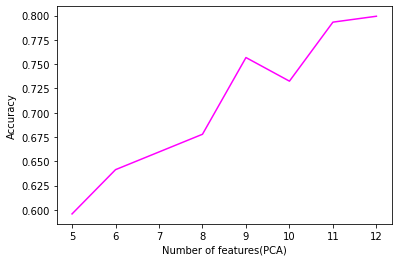

###########################
 # Final Model
 ###########################

Random-Forest final model , [Train] classification weighted accuracy for fold-0:  1.0
Random-Forest final model , [Train] classification weighted accuracy for fold-1:  1.0
Random-Forest final model , [Train] classification weighted accuracy for fold-2:  1.0
Random-Forest final model , [Train] classification weighted accuracy for fold-3:  1.0
Random-Forest final model , [Train] classification weighted accuracy for fold-4:  1.0


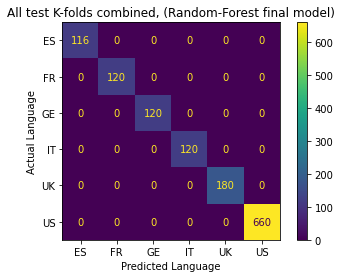

,Language,Accuracy,Precision,Recall,F-score
0,ES,1.0,1.0,1.0,1.0
1,FR,1.0,1.0,1.0,1.0
2,GE,1.0,1.0,1.0,1.0
3,IT,1.0,1.0,1.0,1.0
4,UK,1.0,1.0,1.0,1.0
5,US,1.0,1.0,1.0,1.0
6,Average(weighted),1.0,1.0,1.0,1.0


Random-Forest final model , [Train] average accuracy for all folds:  1.0
RESULT: Random-Forest(Final Model)
	 average-accuracy: 1.0 
	 max-accuracy: 1.0 
	 misclassification-rate: 0.0 


Random-Forest final model , [Test] classification weighted accuracy for fold-0:  0.9090909090909091
Random-Forest final model , [Test] classification weighted accuracy for fold-1:  0.7424242424242424
Random-Forest final model , [Test] classification weighted accuracy for fold-2:  0.803030303030303
Random-Forest final model , [Test] classification weighted accuracy for fold-3:  0.7575757575757576
Random-Forest final model , [Test] classification weighted accuracy for fold-4:  0.7846153846153846


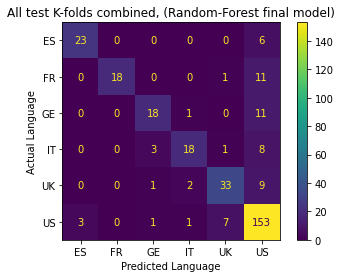

,Language,Accuracy,Precision,Recall,F-score
0,ES,0.793103,0.884615,0.793103,0.836364
1,FR,0.600000,1.000000,0.600000,0.750000
2,GE,0.600000,0.782609,0.600000,0.679245
3,IT,0.600000,0.818182,0.600000,0.692308
4,UK,0.733333,0.785714,0.733333,0.758621
5,US,0.927273,0.772727,0.927273,0.842975
6,Average(weighted),0.799392,0.810136,0.799392,0.793708


Random-Forest final model , [Test] average accuracy for all folds:  0.7993920972644377
RESULT: Random-Forest(Final Model)
	 average-accuracy: 0.7993920972644377 
	 max-accuracy: 0.9090909090909091 
	 misclassification-rate: 0.20060790273556228 


Random-Forest n_estimator=10 , [Test] classification weighted accuracy for fold-0:  0.8181818181818182
Random-Forest n_estimator=10 , [Test] classification weighted accuracy for fold-1:  0.7727272727272727
Random-Forest n_estimator=10 , [Test] classification weighted accuracy for fold-2:  0.7575757575757576
Random-Forest n_estimator=10 , [Test] classification weighted accuracy for fold-3:  0.6818181818181818
Random-Forest n_estimator=10 , [Test] classification weighted accuracy for fold-4:  0.7538461538461538
Random-Forest n_estimator=10 , [Test] average accuracy for all folds:  0.756838905775076
Random-Forest n_estimator=110 , [Test] classification weighted accuracy for fold-0:  0.8636363636363636
Random-Forest n_estimator=110 , [Test] classi

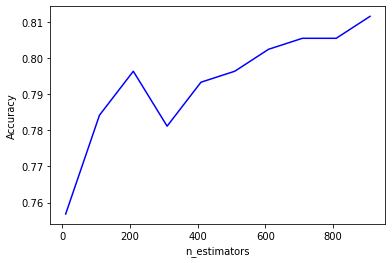

In [200]:
#-----------------------------
# STEP: 1 Run Base Model
#-----------------------------
print(
"###########################\n",
"# Base Model\n",
"###########################\n",
)

config = {
    "use_feature_scaling": False,
    "use_pca": False,
    "use_feature_selector": False,
    "show_each_fold_result": False,
    "show_summary_result": True,
}

for set_type in [setType.Train, setType.Test]:
    avg_accuracy, fold_accuracies = applyClassifier(
        RandomForestClassifier(),
        config, set_type ,"Random-Forest base model"
    )
    print("RESULT: Random-Forest(Base Model)\n\t average-accuracy:", avg_accuracy, "\n\t max-accuracy:",
          max(fold_accuracies), "\n\t misclassification-rate:", (1.0 - avg_accuracy), "\n\n")


#-----------------------------
# STEP: 2 Tune Hyperparameters
#-----------------------------
print(
"###########################\n",
"# parameter tuning\n",
"###########################\n",
)

prev_best = 0
final_parameters = {}
for i in range(0,len(x_train)):
    model = RandomForestClassifier()
    n_estimators = list(range(10,100,20))
    max_features = ['sqrt', 'log2']
    
    # define grid search
    grid = dict(n_estimators=n_estimators,
                max_features=max_features)
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    
    # feature scaling
    scale=StandardScaler()
    X_train = scale.fit_transform(x_train[i])
    X_test = scale.transform(x_test[i])
    grid_result = grid_search.fit(X_train, y_train[i])
    
    # summarize results
    if(grid_result.best_score_ > prev_best):
        final_parameters = grid_result.best_params_
        prev_best = grid_result.best_score_
        
    print("Fold-%d, Best: %f using %s" % (i,grid_result.best_score_, grid_result.best_params_))

print("Final Best: %f using %s" % (prev_best, final_parameters))


#-----------------------------
# STEP 3: Feature selection
#-----------------------------
best_n = 12
do_pca = False
do_fss = False
if setup.skip_subset_selection == False:
    print(
        "###########################\n",
        "# feature selection\n",
        "###########################\n",
    )
    
    ##### forward Subset Selection #####
    config = {
        "use_feature_scaling": True,
        "use_pca": True,
        "use_feature_selector": False,
        "show_each_fold_result": False,
        "show_summary_result": False,
    }
    
    n_features, n_avg_accuracies = classifyWithFeatureSelection(
        RandomForestClassifier(n_estimators=final_parameters['n_estimators'],
                               max_features=final_parameters['max_features']), 
        config, setType.Test, "Random-Forest", False)
    
    # get best 'n'
    best_fss_accuracy = max(n_avg_accuracies)
    best_fss_n = n_features[n_avg_accuracies.index(best_fss_accuracy)]
    print("\nRESULT(Forward subset selection): \n\t best n =", best_fss_n, "\n\t average-accuracy=",
          best_fss_accuracy, "\n\t misclassification-rate:", (1.0 - best_fss_accuracy), "\n\n")

    # plot 'n' vs accuracy
    plt.plot(n_features, n_avg_accuracies, color ='maroon')
    plt.xlabel("Number of features(Forward subset selection)")
    plt.ylabel("Accuracy")
    plt.show()
    
    ##### PCA #####
    config = {
        "use_feature_scaling": True,
        "use_pca": True,
        "use_feature_selector": False,
        "show_each_fold_result": False,
        "show_summary_result": False,
    }

    n_features, n_avg_accuracies = classifyWithFeatureSelection(
        RandomForestClassifier(n_estimators=final_parameters['n_estimators'],
                               max_features=final_parameters['max_features']), 
        config, setType.Test, "Decision-Tree", True)
    
    # get best 'n'
    best_pca_accuracy = max(n_avg_accuracies)
    best_pca_n = n_features[n_avg_accuracies.index(best_pca_accuracy)]
    print("\nRESULT(PCA): \n\t best n =", best_pca_n, "\n\t average-accuracy=", best_pca_accuracy, 
          "\n\t misclassification-rate:", (1.0 - best_pca_accuracy), "\n\n")

    # plot 'n' vs accuracy
    plt.plot(n_features, n_avg_accuracies, color="magenta")
    plt.xlabel("Number of features(PCA)")
    plt.ylabel("Accuracy")
    plt.show()
    
    ##### pick best PCA or FW Subset selection #####
    if(best_pca_accuracy > best_fss_accuracy):
        if(best_pca_n < best_n):
            best_n = best_pca_n
            do_pca = True
    else:
        if(best_fss_n < best_n):
            best_n = best_fss_n
            do_fss = True


            

#-----------------------------
# STEP: 4 Run Final Optimized Model
#-----------------------------
print(
        "###########################\n",
        "# Final Model\n",
        "###########################\n",
    )

config = {
    "use_feature_scaling": True,
    "use_pca": do_pca,
    "use_feature_selector": do_fss,
    "pca_n_features": best_n,
    "feature_selector_n_features": best_n,
    "feature_selector_direction": "forward",
    "show_each_fold_result": False,
    "show_summary_result": True,
}

for set_type in [setType.Train, setType.Test]:
    avg_accuracy, fold_accuracies = applyClassifier(
        RandomForestClassifier(n_estimators=final_parameters['n_estimators'],
                               max_features=final_parameters['max_features']), 
        config, set_type, "Random-Forest final model"
    )
    print("RESULT: Random-Forest(Final Model)\n\t average-accuracy:", avg_accuracy, "\n\t max-accuracy:",
          max(fold_accuracies), "\n\t misclassification-rate:", (1.0 - avg_accuracy), "\n\n")


# plot n_estimators vs accuracy
config = {
    "use_feature_scaling": True,
    "use_pca": do_pca,
    "use_feature_selector": do_fss,
    "pca_n_features": best_n,
    "feature_selector_n_features": best_n,
    "feature_selector_direction": "forward",
    "show_each_fold_result": False,
    "show_summary_result": False,
}
n_est_list = []
accuracy_list = []
for est in range(10,1000,100):
    avg_accuracy, fold_accuracies = applyClassifier(
        RandomForestClassifier(n_estimators=est,
                               max_features=final_parameters['max_features']), 
        config, set_type, "Random-Forest n_estimator={0}".format(est)
    )
    n_est_list.append(est)
    accuracy_list.append(avg_accuracy)
    
# plot 'n' vs accuracy
plt.plot(n_est_list, accuracy_list, color="blue")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.show()
